In [1]:
# !pip install category_encoders
# !pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.8 MB/s eta 0:00:00


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import optuna

In [136]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [137]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/bt4012grpprojdata.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [138]:
display(data.head())
print(data.shape)
data.info()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,0,30,5
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",0,72,8
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22,Davismouth,tablet,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, IL 15564","16282 Dana Falls Suite 790\nRothhaven, IL 15564",0,63,3
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31,Lynnberg,desktop,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, UT 84798","828 Strong Loaf Apt. 646\nNew Joshua, UT 84798",0,124,20
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51,South Nicole,tablet,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, ...","29799 Jason Hills Apt. 439\nWest Richardtown, ...",0,158,5


(1472952, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472952 entries, 0 to 1472951
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Transaction ID      1472952 non-null  object 
 1   Customer ID         1472952 non-null  object 
 2   Transaction Amount  1472952 non-null  float64
 3   Transaction Date    1472952 non-null  object 
 4   Payment Method      1472952 non-null  object 
 5   Product Category    1472952 non-null  object 
 6   Quantity            1472952 non-null  int64  
 7   Customer Age        1472952 non-null  int64  
 8   Customer Location   1472952 non-null  object 
 9   Device Used         1472952 non-null  object 
 10  IP Address          1472952 non-null  object 
 11  Shipping Address    1472952 non-null  object 
 12  Billing Address     1472952 non-null  object 
 13  Is Fraudulent       1472952 non-null  int64  
 14  Account Age Days    1472952 non-null  int64  
 15  T

# Cleaning data columns before splitting

#### Cleaning Customer Age


In [ ]:
# Step 1: Remove rows with ages ≤ 12
data = data[data['Customer Age'] > 12].reset_index(drop=True)  # Reset index after filtering

# Step 2: Add a flag for ages between 13 and 16
data['Parent_Assisted_Purchase'] = ((data['Customer Age'] > 12) &
                                    (data['Customer Age'] < 16)).astype(int)

#### Creating age groups

In [ ]:
def age_groups(x):
    if x < 20:
        return 0
    elif 20 <= x <= 29:
        return 1
    elif 30 <= x <= 39:
        return 2
    elif 40 <= x <= 49:
        return 3
    elif 50 <= x <= 59:
        return 4
    else:
        return 5

data['Age Group'] = data['Customer Age'].apply(age_groups)

#### Cleaning date

In [ ]:
data["Transaction Date"] = pd.to_datetime(data["Transaction Date"])
data['Transaction Day'] = data["Transaction Date"].dt.day.astype(int)
data["Transaction Day of Week"] = data["Transaction Date"].dt.day_of_week.astype(int)
data["Transaction Month"] = data["Transaction Date"].dt.month.astype(int)

#### Creating time of day groups

In [ ]:
def time_of_day_groups(x):
    if x < 6:
        return 0
    elif 6 <= x <= 11:
        return 1
    elif 12 <= x <= 17:
        return 2
    else:
        return 3

data['Time of Day'] = data['Transaction Hour'].apply(time_of_day_groups)

#### Creating isAddressMatched feature

In [ ]:
data['isAddressMatched'] = (data["Shipping Address"] == data["Billing Address"]).astype(int)

#### Creating Price per product feature

In [ ]:
data['Price per product'] = data['Transaction Amount'] / data['Quantity']

#### Creating one-hot encoded features for categorical features

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
features = ['Time of Day', 'Age Group', 'Payment Method', 'Product Category', 'Device Used', 'Transaction Month', 'Transaction Day of Week']
encoded_features = encoder.fit_transform(data[features])
encoded_data = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(features))
encoded_data.head()

final_data = pd.concat([data, encoded_data], axis=1 )

#### Final cleaned data before splitting

In [146]:
display(final_data.head())
print(final_data.shape)
display(final_data.info())

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour,Parent_Assisted_Purchase,Age Group,Transaction Day,Transaction Day of Week,Transaction Month,Time of Day,isAddressMatched,Price per product,Time of Day_0,Time of Day_1,Time of Day_2,Time of Day_3,Age Group_0,Age Group_1,Age Group_2,Age Group_3,Age Group_4,Age Group_5,Payment Method_PayPal,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_clothing,Product Category_electronics,Product Category_health & beauty,Product Category_home & garden,Product Category_toys & games,Device Used_desktop,Device Used_mobile,Device Used_tablet,Transaction Month_1,Transaction Month_2,Transaction Month_3,Transaction Month_4,Transaction Day of Week_0,Transaction Day of Week_1,Transaction Day of Week_2,Transaction Day of Week_3,Transaction Day of Week_4,Transaction Day of Week_5,Transaction Day of Week_6
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,0,30,5,0,0,20,1,2,0,1,58.090,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",0,72,8,0,3,25,6,2,1,1,194.980,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22,Davismouth,tablet,76.63.88.212,"16282 Dana Falls Suite 790\nRothhaven, IL 15564","16282 Dana Falls Suite 790\nRothhaven, IL 15564",0,63,3,0,1,18,0,3,0,1,67.095,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31,Lynnberg,desktop,207.208.171.73,"828 Strong Loaf Apt. 646\nNew Joshua, UT 84798","828 Strong Loaf Apt. 646\nNew Joshua, UT 84798",0,124,20,0,2,16,5,3,3,1,45.234,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51,South Nicole,tablet,190.172.14.169,"29799 Jason Hills Apt. 439\nWest Richardtown, ...","29799 Jason Hills Apt. 439\nWest Richardtown, ...",0,158,5,0,4,15,0,1,0,1,60.765,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


(1452549, 57)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1452549 entries, 0 to 1452548
Data columns (total 57 columns):
 #   Column                            Non-Null Count    Dtype         
---  ------                            --------------    -----         
 0   Transaction ID                    1452549 non-null  object        
 1   Customer ID                       1452549 non-null  object        
 2   Transaction Amount                1452549 non-null  float64       
 3   Transaction Date                  1452549 non-null  datetime64[ns]
 4   Payment Method                    1452549 non-null  object        
 5   Product Category                  1452549 non-null  object        
 6   Quantity                          1452549 non-null  int64         
 7   Customer Age                      1452549 non-null  int64         
 8   Customer Location                 1452549 non-null  object        
 9   Device Used                       1452549 non-null  object        
 10  IP A

None

# Splitting, scaling and cleaning

#### Splitting the data into 70/15/15

In [148]:
# Separate features and target
X = final_data.drop(columns=['Is Fraudulent'])  # Replace with your actual target column name
y = final_data['Is Fraudulent']

# Split into train (70%) and temp (30% for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Split temp into validation (15% of total) and test (15% of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Combine features and target into single DataFrames
train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Check split sizes
print(f"Train set: {train.shape}")
print(f"Validation set: {val.shape}")
print(f"Test set: {test.shape}")

Train set: (1016784, 57)
Validation set: (217882, 57)
Test set: (217883, 57)


In [149]:
train.describe().T

,count,mean,min,25%,50%,75%,max,std
Transaction Amount,1016784.0,226.927384,10.0,68.53,151.92,295.99,12701.75,271.148046
Transaction Date,1016784,2024-02-16 16:30:08.490307072,2024-01-01 00:00:00,2024-01-24 07:47:20.500000,2024-02-16 16:22:36.500000,2024-03-11 00:50:39.500000,2024-04-03 08:13:56,NaN
Quantity,1016784.0,3.0009,1.0,2.0,3.0,4.0,5.0,1.414855
Customer Age,1016784.0,34.866896,13.0,28.0,35.0,41.0,86.0,9.592798
Account Age Days,1016784.0,179.63958,1.0,86.0,179.0,272.0,365.0,106.842756
Transaction Hour,1016784.0,11.285373,0.0,5.0,11.0,17.0,23.0,6.975019
Parent_Assisted_Purchase,1016784.0,0.015178,0.0,0.0,0.0,0.0,1.0,0.122262
Age Group,1016784.0,2.03505,0.0,1.0,2.0,3.0,5.0,1.003234
Transaction Day,1016784.0,15.336134,1.0,8.0,15.0,23.0,31.0,8.935897
Transaction Day of Week,1016784.0,2.945845,0.0,1.0,3.0,5.0,6.0,2.009453


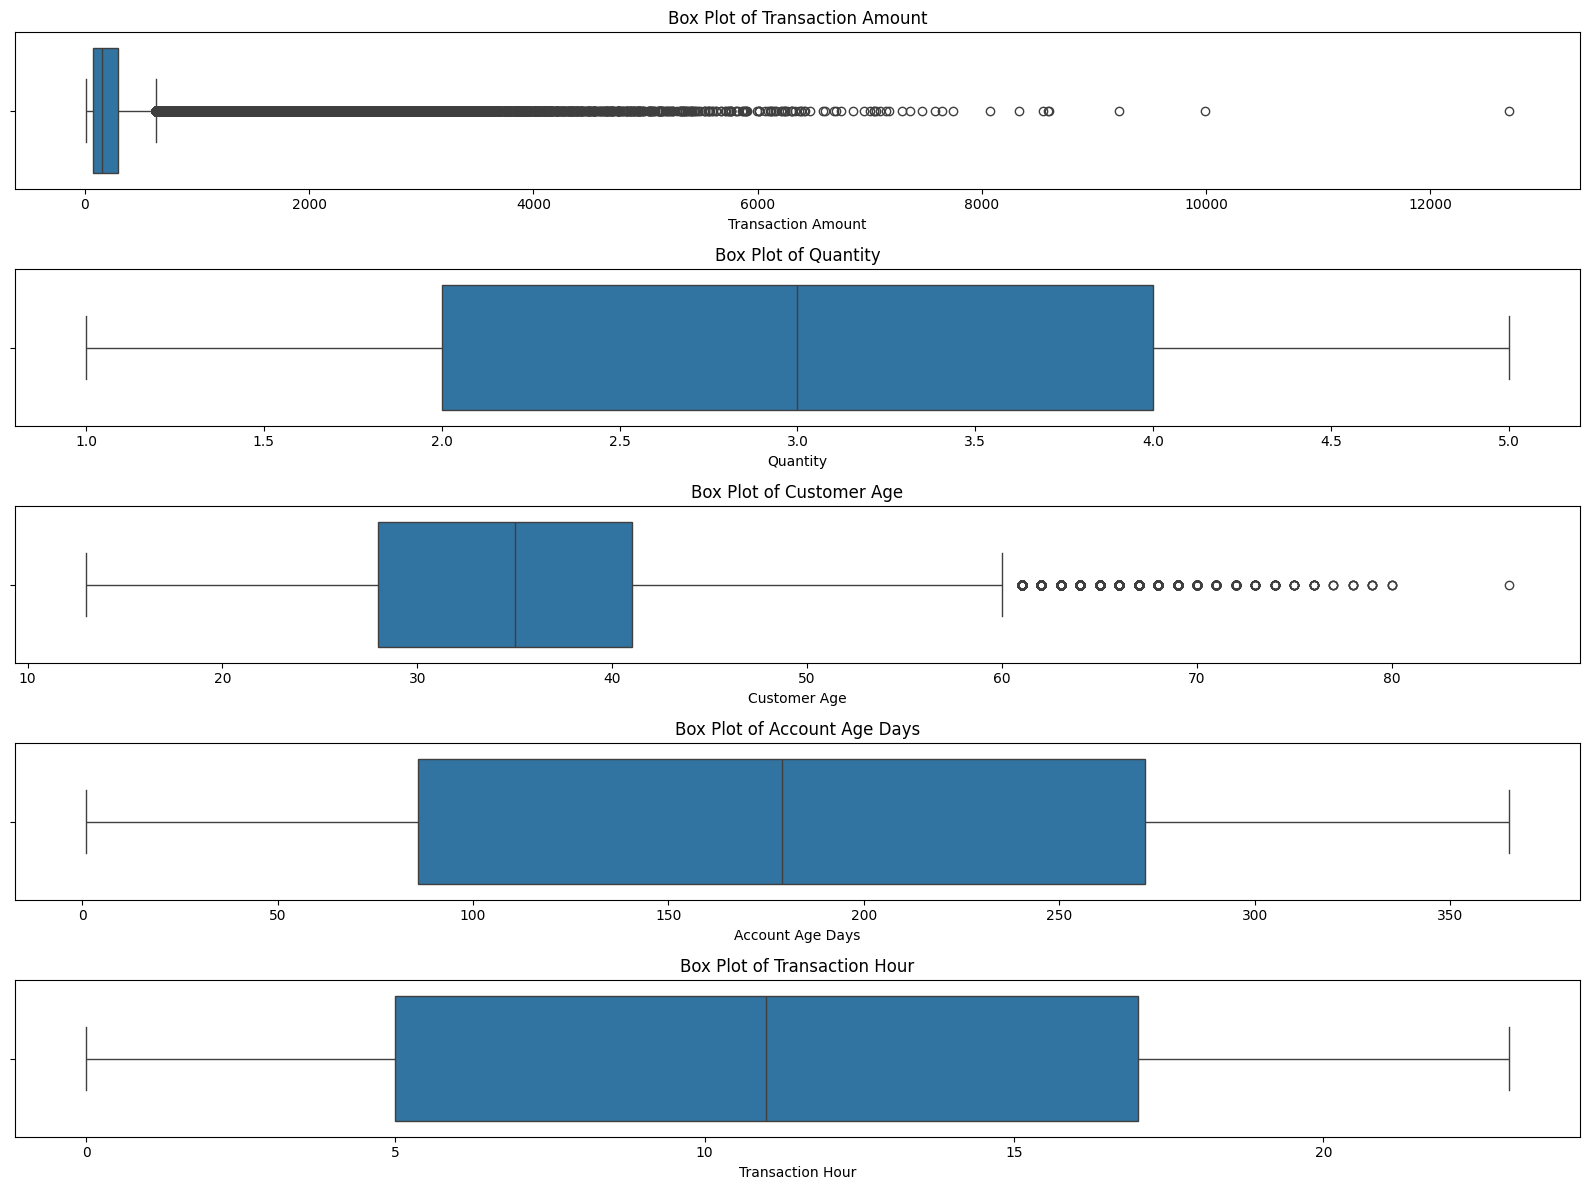

In [150]:
features = ['Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days', 'Transaction Hour']

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x=feature, data=train, ax=axes[i])
    axes[i].set_title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()

#### Cleaning '*Customer Location*' feature

In [151]:
# Import the required library
import category_encoders as ce

# Fit the target encoder on the training set
target_encoder = ce.TargetEncoder(cols=['Customer Location'])
train['custLocEncoded'] = target_encoder.fit_transform(train['Customer Location'], train['Is Fraudulent'])

# Apply the same encoder to the validation and test sets
val['custLocEncoded'] = target_encoder.transform(val['Customer Location'])
test['custLocEncoded'] = target_encoder.transform(test['Customer Location'])

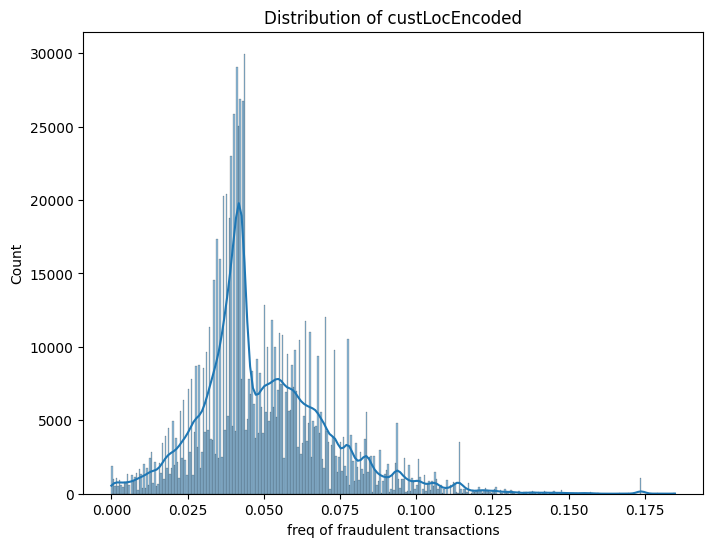

In [152]:
plt.figure(figsize=(8, 6))
sns.histplot(train['custLocEncoded'], kde=True)
plt.xlabel('freq of fraudulent transactions')
plt.ylabel('Count')
plt.title('Distribution of custLocEncoded')
plt.show()

### Oversampling

Dropping columns we don't need

In [153]:
train.drop(columns=[
                    'Transaction ID',
                    'Customer ID',
                    'Transaction Date',
                    'Payment Method',
                    'Product Category',
                    'Customer Location',
                    'Device Used',
                    'Shipping Address',
                    'Billing Address',
                    'IP Address',
                        ], inplace=True)

# do the same for val and test
val = val[train.columns]
test = test[train.columns]

train.head()

,Transaction Amount,Quantity,Customer Age,Account Age Days,Transaction Hour,Parent_Assisted_Purchase,Age Group,Transaction Day,Transaction Day of Week,Transaction Month,Time of Day,isAddressMatched,Price per product,Time of Day_0,Time of Day_1,Time of Day_2,Time of Day_3,Age Group_0,Age Group_1,Age Group_2,Age Group_3,Age Group_4,Age Group_5,Payment Method_PayPal,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_clothing,Product Category_electronics,Product Category_health & beauty,Product Category_home & garden,Product Category_toys & games,Device Used_desktop,Device Used_mobile,Device Used_tablet,Transaction Month_1,Transaction Month_2,Transaction Month_3,Transaction Month_4,Transaction Day of Week_0,Transaction Day of Week_1,Transaction Day of Week_2,Transaction Day of Week_3,Transaction Day of Week_4,Transaction Day of Week_5,Transaction Day of Week_6,Is Fraudulent,custLocEncoded
904466,108.85,4,41,342,23,0,3,15,3,2,3,1,27.2125,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.036170
394104,24.90,5,24,155,15,0,1,21,3,3,2,1,4.9800,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.018924
503616,18.20,4,22,237,16,0,1,28,6,1,2,1,4.5500,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.041705
304747,366.46,1,29,85,12,0,1,13,5,1,2,1,366.4600,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.060421
131498,25.79,2,27,133,5,0,1,18,6,2,0,0,12.8950,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.041705


Oversampling

In [154]:
from imblearn.over_sampling import SMOTE

# Define features (X_train) and target (y_train) for the training set
X_train = train.drop(columns=['Is Fraudulent'])
y_train = train['Is Fraudulent']

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

# Convert back to a DataFrame for consistency
train_oversampled = pd.DataFrame(X_train_oversampled, columns=X_train.columns)
train_oversampled['Is Fraudulent'] = y_train_oversampled

# Check the distribution of the target variable after oversampling
print("Original training set class distribution:")
print(y_train.value_counts())
print("\nOversampled training set class distribution:")
print(y_train_oversampled.value_counts())

# Display the oversampled training set
train_oversampled.head()

Original training set class distribution:
Is Fraudulent
0    965817
1     50967
Name: count, dtype: int64

Oversampled training set class distribution:
Is Fraudulent
0    965817
1    965817
Name: count, dtype: int64


,Transaction Amount,Quantity,Customer Age,Account Age Days,Transaction Hour,Parent_Assisted_Purchase,Age Group,Transaction Day,Transaction Day of Week,Transaction Month,Time of Day,isAddressMatched,Price per product,Time of Day_0,Time of Day_1,Time of Day_2,Time of Day_3,Age Group_0,Age Group_1,Age Group_2,Age Group_3,Age Group_4,Age Group_5,Payment Method_PayPal,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_clothing,Product Category_electronics,Product Category_health & beauty,Product Category_home & garden,Product Category_toys & games,Device Used_desktop,Device Used_mobile,Device Used_tablet,Transaction Month_1,Transaction Month_2,Transaction Month_3,Transaction Month_4,Transaction Day of Week_0,Transaction Day of Week_1,Transaction Day of Week_2,Transaction Day of Week_3,Transaction Day of Week_4,Transaction Day of Week_5,Transaction Day of Week_6,custLocEncoded,Is Fraudulent
0,108.85,4,41,342,23,0,3,15,3,2,3,1,27.2125,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.036170,0
1,24.90,5,24,155,15,0,1,21,3,3,2,1,4.9800,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.018924,0
2,18.20,4,22,237,16,0,1,28,6,1,2,1,4.5500,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.041705,0
3,366.46,1,29,85,12,0,1,13,5,1,2,1,366.4600,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.060421,0
4,25.79,2,27,133,5,0,1,18,6,2,0,0,12.8950,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.041705,0


### Scaling

#### Scaling Transaction Amount

In [155]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the original training set and scale
train['Transaction Amount Rescaled'] = np.log10(train['Transaction Amount'])
train['Transaction Amount Rescaled'] = scaler.fit_transform(train[['Transaction Amount Rescaled']])

# Apply the fitted scaler to the validation set
val['Transaction Amount Rescaled'] = np.log10(val['Transaction Amount'])
val['Transaction Amount Rescaled'] = scaler.transform(val[['Transaction Amount Rescaled']])

# Apply the fitted scaler to the test set
test['Transaction Amount Rescaled'] = np.log10(test['Transaction Amount'])
test['Transaction Amount Rescaled'] = scaler.transform(test[['Transaction Amount Rescaled']])

# Apply the fitted scaler to the oversampled training set
train_oversampled['Transaction Amount Rescaled'] = np.log10(train_oversampled['Transaction Amount'])
train_oversampled['Transaction Amount Rescaled'] = scaler.transform(train_oversampled[['Transaction Amount Rescaled']])

# Confirm scaling applied successfully
print("Scaling applied to train, val, test, and train_oversampled datasets based on original train data.")


Scaling applied to train, val, test, and train_oversampled datasets based on original train data.


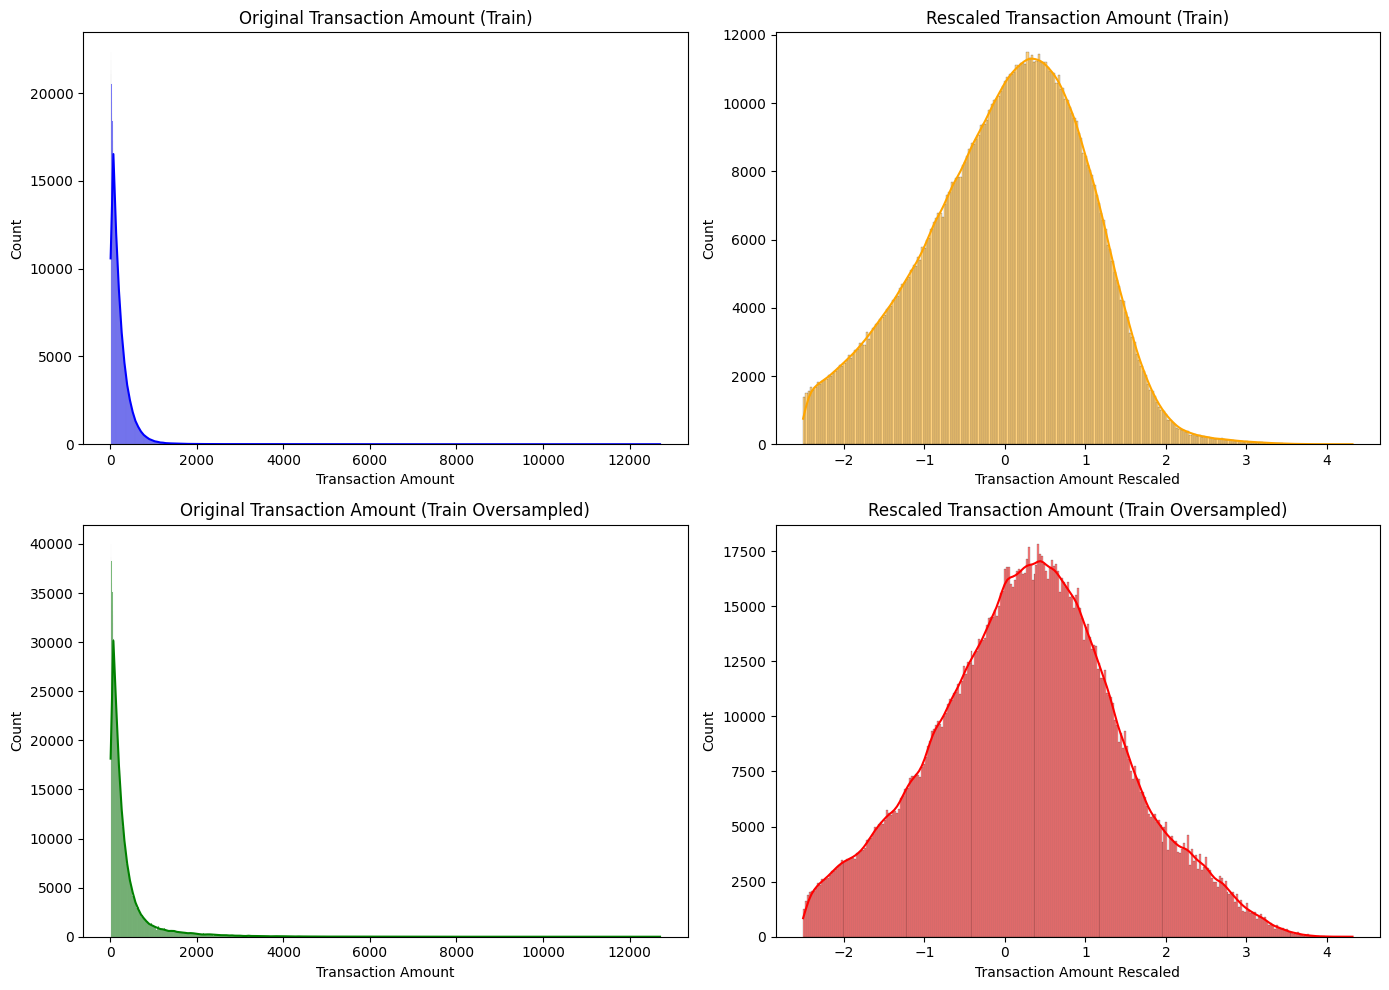

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Adjust figure size as needed

# Plot the original Transaction Amount for the train set
sns.histplot(train['Transaction Amount'], kde=True, color='blue', ax=axes[0, 0])
axes[0, 0].set_xlabel('Transaction Amount')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Original Transaction Amount (Train)')

# Plot the rescaled Transaction Amount for the train set
sns.histplot(train['Transaction Amount Rescaled'], kde=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_xlabel('Transaction Amount Rescaled')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Rescaled Transaction Amount (Train)')

# Plot the original Transaction Amount for the train_oversampled set
sns.histplot(train_oversampled['Transaction Amount'], kde=True, color='green', ax=axes[1, 0])
axes[1, 0].set_xlabel('Transaction Amount')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Original Transaction Amount (Train Oversampled)')

# Plot the rescaled Transaction Amount for the train_oversampled set
sns.histplot(train_oversampled['Transaction Amount Rescaled'], kde=True, color='red', ax=axes[1, 1])
axes[1, 1].set_xlabel('Transaction Amount Rescaled')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Rescaled Transaction Amount (Train Oversampled)')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


#### Scaling Account Age

In [157]:
# Initialize scaler
scaler_account_age = StandardScaler()

# Log transformation and scaling for the training set
train['Account Age Rescaled'] = np.log10(train['Account Age Days'])
train['Account Age Rescaled'] = scaler_account_age.fit_transform(train[['Account Age Rescaled']])

# Apply the fitted scaler to the oversampled training set
train_oversampled['Account Age Rescaled'] = np.log10(train_oversampled['Account Age Days'])
train_oversampled['Account Age Rescaled'] = scaler_account_age.transform(train_oversampled[['Account Age Rescaled']])

# Apply the fitted scaler to the validation set
val['Account Age Rescaled'] = np.log10(val['Account Age Days'])
val['Account Age Rescaled'] = scaler_account_age.transform(val[['Account Age Rescaled']])

# Apply the fitted scaler to the test set
test['Account Age Rescaled'] = np.log10(test['Account Age Days'])
test['Account Age Rescaled'] = scaler_account_age.transform(test[['Account Age Rescaled']])


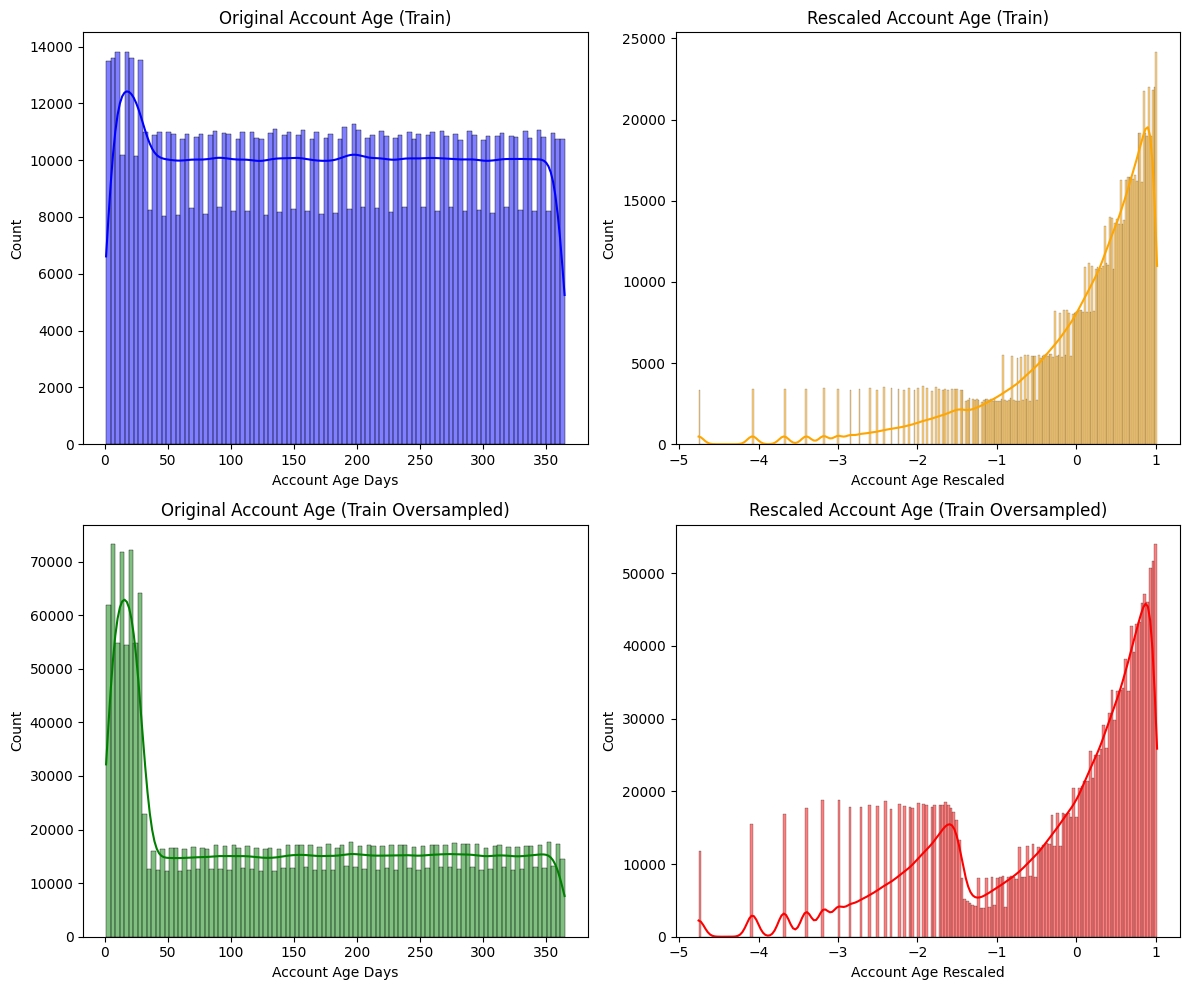

In [158]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Original Account Age for train
sns.histplot(train['Account Age Days'], kde=True, color='blue', ax=axes[0, 0])
axes[0, 0].set_title('Original Account Age (Train)')
axes[0, 0].set_xlabel('Account Age Days')
axes[0, 0].set_ylabel('Count')

# Rescaled Account Age for train
sns.histplot(train['Account Age Rescaled'], kde=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_title('Rescaled Account Age (Train)')
axes[0, 1].set_xlabel('Account Age Rescaled')
axes[0, 1].set_ylabel('Count')

# Original Account Age for train_oversampled
sns.histplot(train_oversampled['Account Age Days'], kde=True, color='green', ax=axes[1, 0])
axes[1, 0].set_title('Original Account Age (Train Oversampled)')
axes[1, 0].set_xlabel('Account Age Days')
axes[1, 0].set_ylabel('Count')

# Rescaled Account Age for train_oversampled
sns.histplot(train_oversampled['Account Age Rescaled'], kde=True, color='red', ax=axes[1, 1])
axes[1, 1].set_title('Rescaled Account Age (Train Oversampled)')
axes[1, 1].set_xlabel('Account Age Rescaled')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()


#### Scaling Price per product

In [159]:
# Initialize the scaler
scaler = StandardScaler()

# Rescale product price for training set
train['Product Price Rescaled'] = train['Price per product'].apply(lambda x: np.log10(x))
train['Product Price Rescaled'] = scaler.fit_transform(train[['Product Price Rescaled']])

# Rescale product price for training oversampled set
train_oversampled['Product Price Rescaled'] = train_oversampled['Price per product'].apply(lambda x: np.log10(x))
train_oversampled['Product Price Rescaled'] = scaler.transform(train_oversampled[['Product Price Rescaled']])

# Rescale product price for validation set
val['Product Price Rescaled'] = val['Price per product'].apply(lambda x: np.log10(x))
val['Product Price Rescaled'] = scaler.transform(val[['Product Price Rescaled']])

# Rescale product price for test set
test['Product Price Rescaled'] = test['Price per product'].apply(lambda x: np.log10(x))
test['Product Price Rescaled'] = scaler.transform(test[['Product Price Rescaled']])


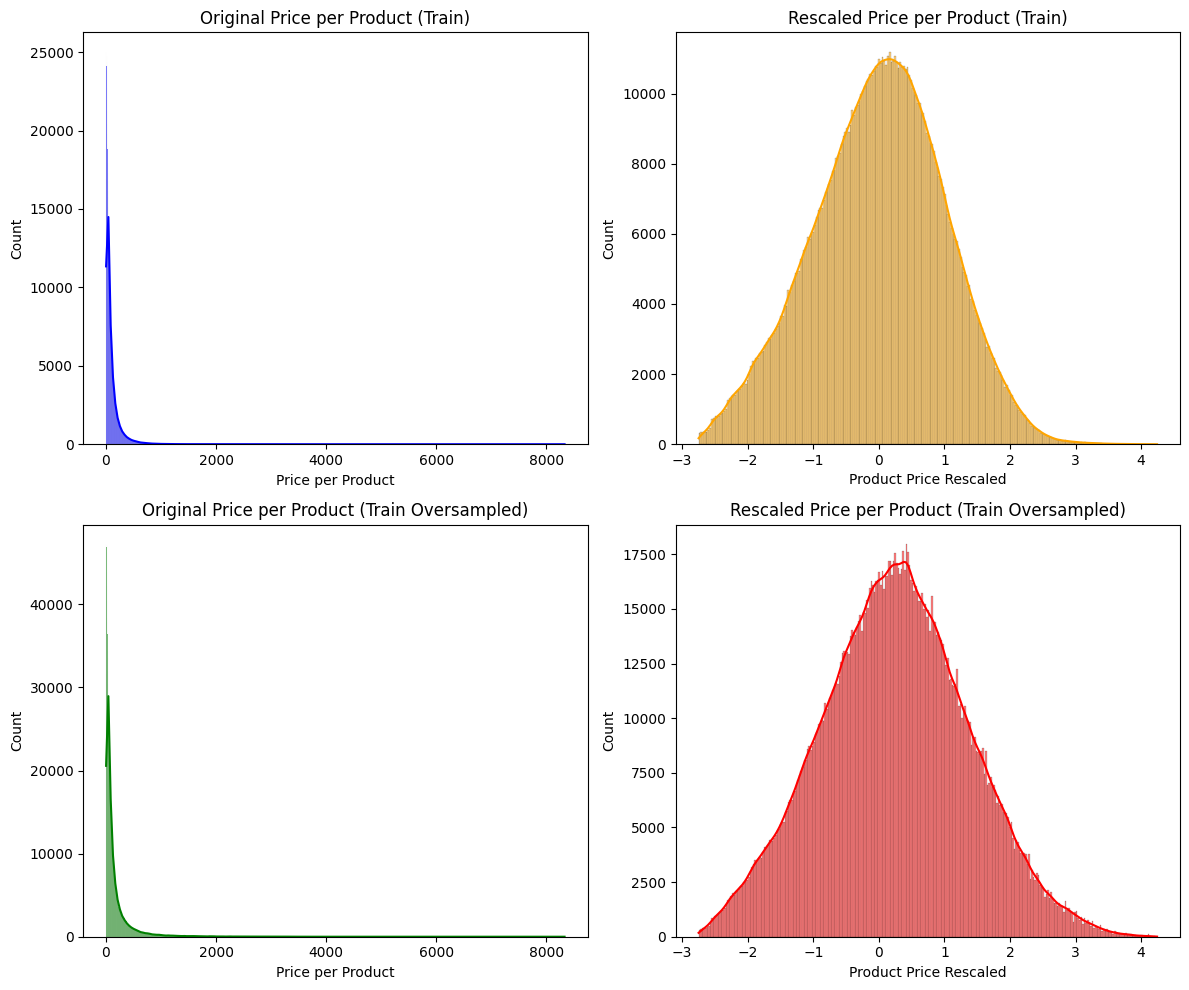

In [160]:
# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Original Price per Product distribution (Train)
sns.histplot(train['Price per product'], kde=True, color='blue', ax=axes[0, 0])
axes[0, 0].set_xlabel('Price per Product')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Original Price per Product (Train)')

# Rescaled Price per Product distribution (Train)
sns.histplot(train['Product Price Rescaled'], kde=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_xlabel('Product Price Rescaled')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Rescaled Price per Product (Train)')

# Original Price per Product distribution (Train Oversampled)
sns.histplot(train_oversampled['Price per product'], kde=True, color='green', ax=axes[1, 0])
axes[1, 0].set_xlabel('Price per Product')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Original Price per Product (Train Oversampled)')

# Rescaled Price per Product distribution (Train Oversampled)
sns.histplot(train_oversampled['Product Price Rescaled'], kde=True, color='red', ax=axes[1, 1])
axes[1, 1].set_xlabel('Product Price Rescaled')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Rescaled Price per Product (Train Oversampled)')

# Adjust layout
plt.tight_layout()
plt.show()


#### Scaling Quantity

In [161]:
# Initialize the Min-Max Scaler
min_max_scaler = MinMaxScaler()

# Apply Min-Max Scaling to 'Quantity' for the training set
train['Quantity_Scaled'] = min_max_scaler.fit_transform(train[['Quantity']])

# Apply the fitted scaler to transform the validation, test, and train_oversampled sets
val['Quantity_Scaled'] = min_max_scaler.transform(val[['Quantity']])
test['Quantity_Scaled'] = min_max_scaler.transform(test[['Quantity']])
train_oversampled['Quantity_Scaled'] = min_max_scaler.transform(train_oversampled[['Quantity']])


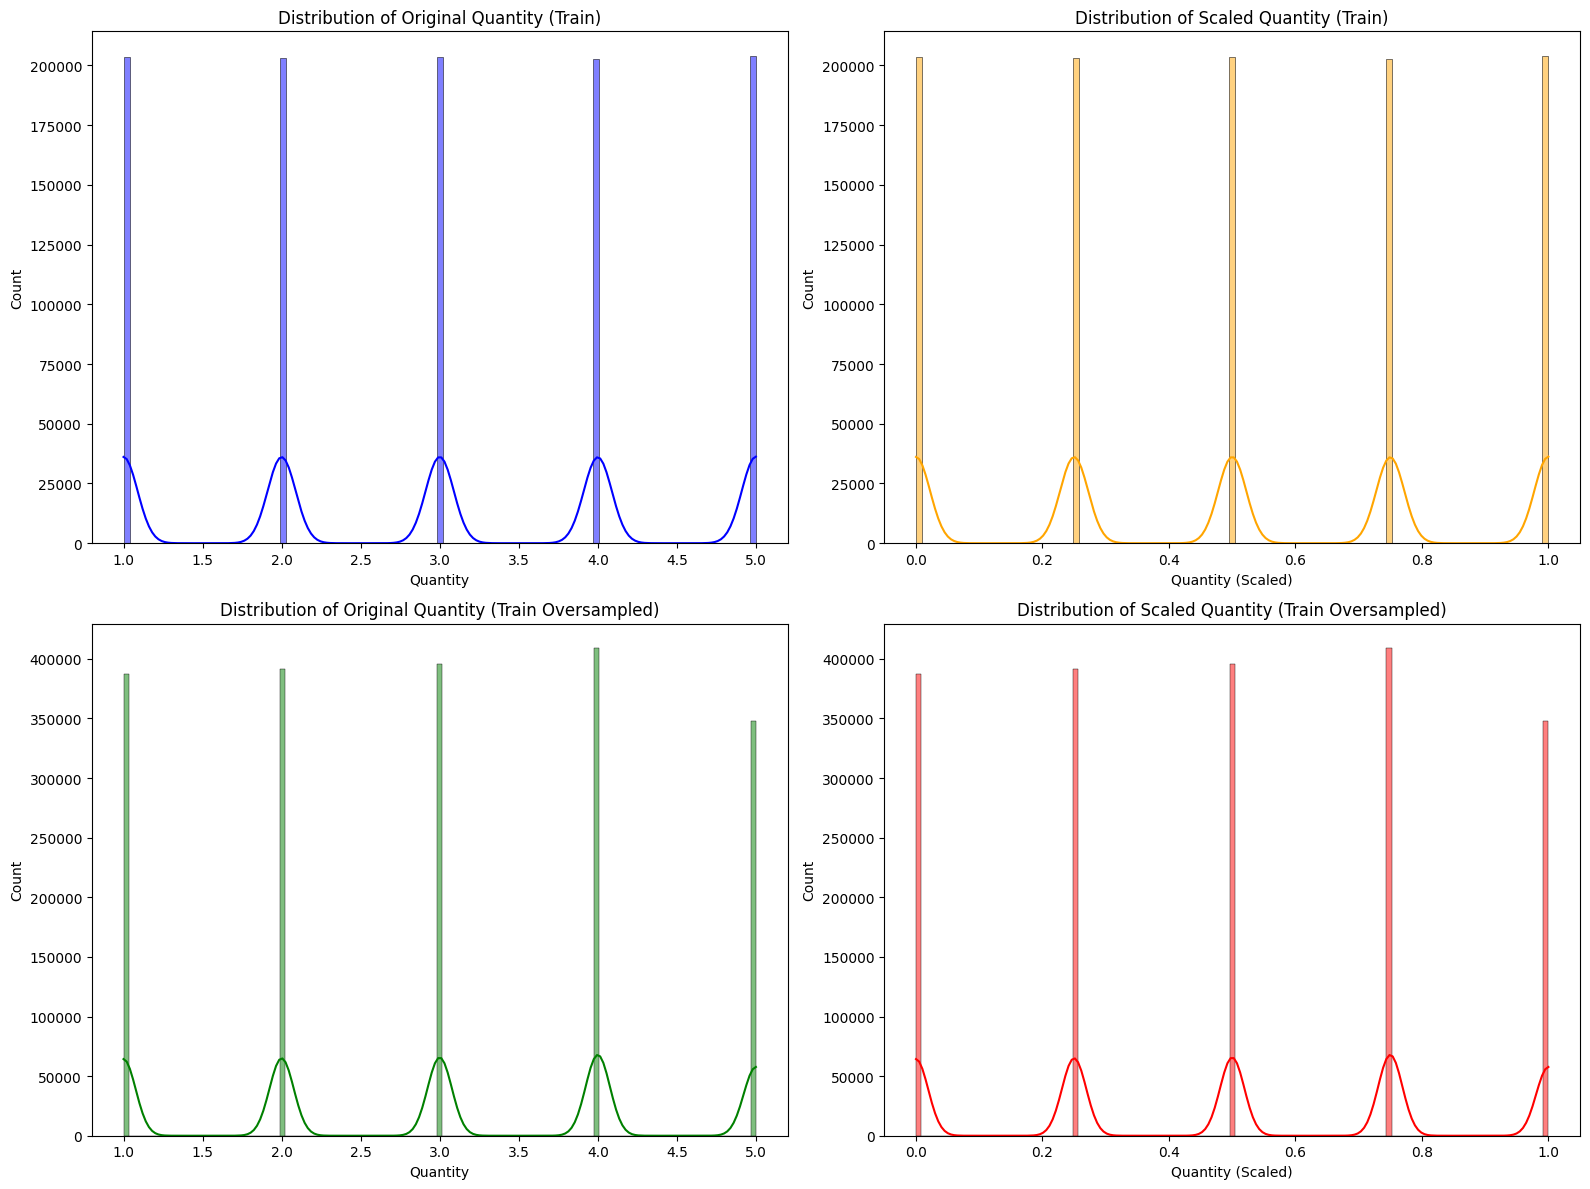

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Original Quantity distribution (Train)
sns.histplot(train['Quantity'], kde=True, color='blue', ax=axes[0, 0])
axes[0, 0].set_xlabel('Quantity')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Distribution of Original Quantity (Train)')

# Scaled Quantity distribution (Train)
sns.histplot(train['Quantity_Scaled'], kde=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_xlabel('Quantity (Scaled)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Distribution of Scaled Quantity (Train)')

# Original Quantity distribution (Train Oversampled)
sns.histplot(train_oversampled['Quantity'], kde=True, color='green', ax=axes[1, 0])
axes[1, 0].set_xlabel('Quantity')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Distribution of Original Quantity (Train Oversampled)')

# Scaled Quantity distribution (Train Oversampled)
sns.histplot(train_oversampled['Quantity_Scaled'], kde=True, color='red', ax=axes[1, 1])
axes[1, 1].set_xlabel('Quantity (Scaled)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Distribution of Scaled Quantity (Train Oversampled)')

plt.tight_layout()
plt.show()


#### Scaling Customer Age

In [163]:
# Initialize the Standard Scaler
standard_scaler = StandardScaler()

# Apply Standardization to 'Customer Age' for the training set
train['Customer Age_Scaled'] = standard_scaler.fit_transform(train[['Customer Age']])

# Use the fitted scaler to transform the validation, test, and oversampled train sets
val['Customer Age_Scaled'] = standard_scaler.transform(val[['Customer Age']])
test['Customer Age_Scaled'] = standard_scaler.transform(test[['Customer Age']])
train_oversampled['Customer Age_Scaled'] = standard_scaler.transform(train_oversampled[['Customer Age']])


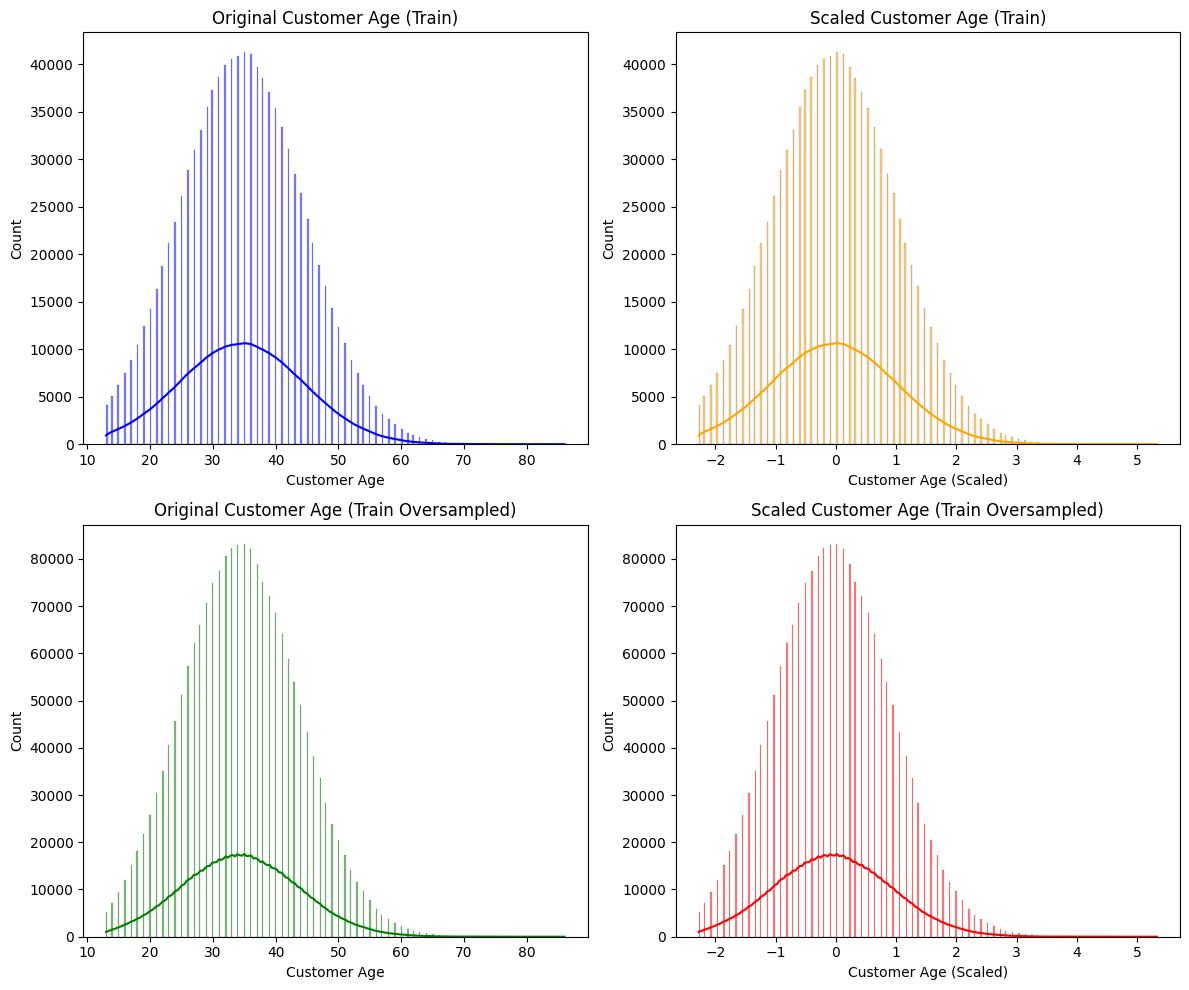

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Original Customer Age distribution (Train)
sns.histplot(train['Customer Age'], kde=True, color='blue', ax=axes[0, 0])
axes[0, 0].set_xlabel('Customer Age')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Original Customer Age (Train)')

# Scaled Customer Age distribution (Train)
sns.histplot(train['Customer Age_Scaled'], kde=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_xlabel('Customer Age (Scaled)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Scaled Customer Age (Train)')

# Original Customer Age distribution (Train Oversampled)
sns.histplot(train_oversampled['Customer Age'], kde=True, color='green', ax=axes[1, 0])
axes[1, 0].set_xlabel('Customer Age')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Original Customer Age (Train Oversampled)')

# Scaled Customer Age distribution (Train Oversampled)
sns.histplot(train_oversampled['Customer Age_Scaled'], kde=True, color='red', ax=axes[1, 1])
axes[1, 1].set_xlabel('Customer Age (Scaled)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Scaled Customer Age (Train Oversampled)')

# Adjust layout for better display
plt.tight_layout()
plt.show()


### After all cleaning is done

In [165]:
display(train.head())
print(train.shape)
#Kegan wrongly applied the time of day function
#I scaled quantity and customer age for my own use

,Transaction Amount,Quantity,Customer Age,Account Age Days,Transaction Hour,Parent_Assisted_Purchase,Age Group,Transaction Day,Transaction Day of Week,Transaction Month,Time of Day,isAddressMatched,Price per product,Time of Day_0,Time of Day_1,Time of Day_2,Time of Day_3,Age Group_0,Age Group_1,Age Group_2,Age Group_3,Age Group_4,Age Group_5,Payment Method_PayPal,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_clothing,Product Category_electronics,Product Category_health & beauty,Product Category_home & garden,Product Category_toys & games,Device Used_desktop,Device Used_mobile,Device Used_tablet,Transaction Month_1,Transaction Month_2,Transaction Month_3,Transaction Month_4,Transaction Day of Week_0,Transaction Day of Week_1,Transaction Day of Week_2,Transaction Day of Week_3,Transaction Day of Week_4,Transaction Day of Week_5,Transaction Day of Week_6,Is Fraudulent,custLocEncoded,Transaction Amount Rescaled,Account Age Rescaled,Product Price Rescaled,Quantity_Scaled,Customer Age_Scaled
904466,108.85,4,41,342,23,0,3,15,3,2,3,1,27.2125,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.036170,-0.227555,0.950660,-0.559452,0.75,0.639345
394104,24.90,5,24,155,15,0,1,21,3,3,2,1,4.9800,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.018924,-1.636327,0.176885,-1.984235,1.00,-1.132819
503616,18.20,4,22,237,16,0,1,28,6,1,2,1,4.5500,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.041705,-1.935679,0.592071,-2.059997,0.75,-1.341309
304747,366.46,1,29,85,12,0,1,13,5,1,2,1,366.4600,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.060421,0.931777,-0.410520,1.622058,0.00,-0.611594
131498,25.79,2,27,133,5,0,1,18,6,2,0,0,12.8950,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.041705,-1.602787,0.027215,-1.186028,0.25,-0.820084


(1016784, 53)


In [166]:
display(train_oversampled.head())
print(train_oversampled.shape)

,Transaction Amount,Quantity,Customer Age,Account Age Days,Transaction Hour,Parent_Assisted_Purchase,Age Group,Transaction Day,Transaction Day of Week,Transaction Month,Time of Day,isAddressMatched,Price per product,Time of Day_0,Time of Day_1,Time of Day_2,Time of Day_3,Age Group_0,Age Group_1,Age Group_2,Age Group_3,Age Group_4,Age Group_5,Payment Method_PayPal,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_clothing,Product Category_electronics,Product Category_health & beauty,Product Category_home & garden,Product Category_toys & games,Device Used_desktop,Device Used_mobile,Device Used_tablet,Transaction Month_1,Transaction Month_2,Transaction Month_3,Transaction Month_4,Transaction Day of Week_0,Transaction Day of Week_1,Transaction Day of Week_2,Transaction Day of Week_3,Transaction Day of Week_4,Transaction Day of Week_5,Transaction Day of Week_6,custLocEncoded,Is Fraudulent,Transaction Amount Rescaled,Account Age Rescaled,Product Price Rescaled,Quantity_Scaled,Customer Age_Scaled
0,108.85,4,41,342,23,0,3,15,3,2,3,1,27.2125,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.036170,0,-0.227555,0.950660,-0.559452,0.75,0.639345
1,24.90,5,24,155,15,0,1,21,3,3,2,1,4.9800,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.018924,0,-1.636327,0.176885,-1.984235,1.00,-1.132819
2,18.20,4,22,237,16,0,1,28,6,1,2,1,4.5500,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.041705,0,-1.935679,0.592071,-2.059997,0.75,-1.341309
3,366.46,1,29,85,12,0,1,13,5,1,2,1,366.4600,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.060421,0,0.931777,-0.410520,1.622058,0.00,-0.611594
4,25.79,2,27,133,5,0,1,18,6,2,0,0,12.8950,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.041705,0,-1.602787,0.027215,-1.186028,0.25,-0.820084


(1931634, 53)


# Features chosen for my model

In [176]:
chosen_features = ['Transaction Amount Rescaled', 'Transaction Month_1', 'Transaction Month_2', 'Transaction Month_3', 'Transaction Month_4',
                    'Transaction Day of Week_0', 'Transaction Day of Week_1', 'Transaction Day of Week_2', 'Transaction Day of Week_3', 'Transaction Day of Week_4', 'Transaction Day of Week_5', 'Transaction Day of Week_6',
                    'Payment Method_PayPal', 'Payment Method_bank transfer', 'Payment Method_credit card', 'Payment Method_debit card',
                    'Product Category_clothing', 'Product Category_electronics', 'Product Category_health & beauty', 'Product Category_home & garden', 'Product Category_toys & games',
                    'Quantity_Scaled', 'Product Price Rescaled', 'Customer Age_Scaled', 'Parent_Assisted_Purchase', 'custLocEncoded', 'Device Used_desktop', 'Device Used_mobile', 'Device Used_tablet', 'isAddressMatched', 'Account Age Rescaled', 'Time of Day_0', 'Time of Day_1', 'Time of Day_2', 'Time of Day_3', 'Is Fraudulent']

train_copy = train.copy()
train_oversampled_copy = train_oversampled.copy()
val_copy = val.copy()
test_copy = test.copy()

train_cleaned = train_copy[chosen_features]
train_oversampled_cleaned = train_oversampled_copy[chosen_features]
val_cleaned = val_copy[chosen_features]
test_cleaned = test_copy[chosen_features]

display(train_cleaned.head())
print(train_cleaned.shape)

display(train_oversampled_cleaned.head())
print(train_oversampled_cleaned.shape)

,Transaction Amount Rescaled,Transaction Month_1,Transaction Month_2,Transaction Month_3,Transaction Month_4,Transaction Day of Week_0,Transaction Day of Week_1,Transaction Day of Week_2,Transaction Day of Week_3,Transaction Day of Week_4,Transaction Day of Week_5,Transaction Day of Week_6,Payment Method_PayPal,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_clothing,Product Category_electronics,Product Category_health & beauty,Product Category_home & garden,Product Category_toys & games,Quantity_Scaled,Product Price Rescaled,Customer Age_Scaled,Parent_Assisted_Purchase,custLocEncoded,Device Used_desktop,Device Used_mobile,Device Used_tablet,isAddressMatched,Account Age Rescaled,Time of Day_0,Time of Day_1,Time of Day_2,Time of Day_3,Is Fraudulent
904466,-0.227555,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.75,-0.559452,0.639345,0,0.036170,0.0,1.0,0.0,1,0.950660,0.0,0.0,0.0,1.0,0
394104,-1.636327,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.00,-1.984235,-1.132819,0,0.018924,0.0,0.0,1.0,1,0.176885,0.0,0.0,1.0,0.0,0
503616,-1.935679,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.75,-2.059997,-1.341309,0,0.041705,1.0,0.0,0.0,1,0.592071,0.0,0.0,1.0,0.0,0
304747,0.931777,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00,1.622058,-0.611594,0,0.060421,0.0,0.0,1.0,1,-0.410520,0.0,0.0,1.0,0.0,0
131498,-1.602787,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.25,-1.186028,-0.820084,0,0.041705,1.0,0.0,0.0,0,0.027215,1.0,0.0,0.0,0.0,0


(1016784, 36)


,Transaction Amount Rescaled,Transaction Month_1,Transaction Month_2,Transaction Month_3,Transaction Month_4,Transaction Day of Week_0,Transaction Day of Week_1,Transaction Day of Week_2,Transaction Day of Week_3,Transaction Day of Week_4,Transaction Day of Week_5,Transaction Day of Week_6,Payment Method_PayPal,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_clothing,Product Category_electronics,Product Category_health & beauty,Product Category_home & garden,Product Category_toys & games,Quantity_Scaled,Product Price Rescaled,Customer Age_Scaled,Parent_Assisted_Purchase,custLocEncoded,Device Used_desktop,Device Used_mobile,Device Used_tablet,isAddressMatched,Account Age Rescaled,Time of Day_0,Time of Day_1,Time of Day_2,Time of Day_3,Is Fraudulent
0,-0.227555,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.75,-0.559452,0.639345,0,0.036170,0.0,1.0,0.0,1,0.950660,0.0,0.0,0.0,1.0,0
1,-1.636327,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.00,-1.984235,-1.132819,0,0.018924,0.0,0.0,1.0,1,0.176885,0.0,0.0,1.0,0.0,0
2,-1.935679,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.75,-2.059997,-1.341309,0,0.041705,1.0,0.0,0.0,1,0.592071,0.0,0.0,1.0,0.0,0
3,0.931777,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00,1.622058,-0.611594,0,0.060421,0.0,0.0,1.0,1,-0.410520,0.0,0.0,1.0,0.0,0
4,-1.602787,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.25,-1.186028,-0.820084,0,0.041705,1.0,0.0,0.0,0,0.027215,1.0,0.0,0.0,0.0,0


(1931634, 36)


#### Preparing the data to be fed into model

In [177]:
# Separate features and target for the normal training set
X_train = train_cleaned.drop(columns=['Is Fraudulent'])  # Features
y_train = train_cleaned['Is Fraudulent']  # Target

# Separate features and target for the oversampled training set
X_train_oversampled = train_oversampled_cleaned.drop(columns=['Is Fraudulent'])  # Features
y_train_oversampled = train_oversampled_cleaned['Is Fraudulent']  # Target

# Separate features and target for the validation set
X_val = val_cleaned.drop(columns=['Is Fraudulent'])  # Features
y_val = val_cleaned['Is Fraudulent']  # Target

# Separate features and target for the test set
X_test = test_cleaned.drop(columns=['Is Fraudulent'])  # Features
y_test = test_cleaned['Is Fraudulent']  # Target

# Print shapes to confirm splits
print("Normal Training Set:")
print(f"Features: {X_train.shape}, Target: {y_train.shape}")
print("\nOversampled Training Set:")
print(f"Features: {X_train_oversampled.shape}, Target: {y_train_oversampled.shape}")
print("\nValidation Set:")
print(f"Features: {X_val.shape}, Target: {y_val.shape}")
print("\nTest Set:")
print(f"Features: {X_test.shape}, Target: {y_test.shape}")


Normal Training Set:
Features: (1016784, 35), Target: (1016784,)

Oversampled Training Set:
Features: (1931634, 35), Target: (1931634,)

Validation Set:
Features: (217882, 35), Target: (217882,)

Test Set:
Features: (217883, 35), Target: (217883,)


# Deep Learning

#### Implements a fraud detection model using Binary Cross-Entropy Loss (BCELoss), which treats all samples equally during training.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
import optuna

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Define the PyTorch Model
class FraudNet(nn.Module):
    def __init__(self, input_dim, hidden_layers, units_per_layer, dropout_rate):
        super(FraudNet, self).__init__()
        layers = []
        current_dim = input_dim

        # Add hidden layers
        for _ in range(hidden_layers):
            layers.append(nn.Linear(current_dim, units_per_layer))
            layers.append(nn.BatchNorm1d(units_per_layer))  # Batch Normalization
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            current_dim = units_per_layer

        # Add output layer
        layers.append(nn.Linear(current_dim, 1))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Objective Function for Optuna
def objective(trial):
    # Hyperparameters to tune
    hidden_layers = trial.suggest_int("hidden_layers", 2, 4)
    units_per_layer = trial.suggest_int("units_per_layer", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.3, step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 0.005, 0.01, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-4, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])

    # Initialize the model
    input_dim = X_train.shape[1]
    model = FraudNet(input_dim, hidden_layers, units_per_layer, dropout_rate)
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # DataLoader for batching
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    model.train()
    for epoch in range(10):  # Train for 10 epochs
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_auc = roc_auc_score(y_val.numpy(), val_outputs.numpy())  # Calculate validation AUC

    # Return validation AUC as the objective to optimize
    return val_auc

# Run Optuna for Hyperparameter Tuning
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Best Hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the Best Model with AUC Tracking
best_model = FraudNet(
    input_dim=X_train.shape[1],
    hidden_layers=best_params["hidden_layers"],
    units_per_layer=best_params["units_per_layer"],
    dropout_rate=best_params["dropout_rate"]
)
criterion = nn.BCELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_params["learning_rate"], weight_decay=best_params["weight_decay"])

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)

train_aucs = []
val_aucs = []

# Training loop
best_model.train()
for epoch in range(10):  # Train for 10 epochs
    y_train_true = []
    y_train_pred = []

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = best_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        # Store true and predicted values for AUC calculation
        y_train_true.extend(batch_y.numpy())
        y_train_pred.extend(outputs.detach().numpy())

    # Calculate training AUC
    train_auc = roc_auc_score(y_train_true, y_train_pred)
    train_aucs.append(train_auc)

    # Validation AUC
    best_model.eval()
    with torch.no_grad():
        val_outputs = best_model(X_val)
        val_auc = roc_auc_score(y_val.numpy(), val_outputs.numpy())
        val_aucs.append(val_auc)

    best_model.train()  # Switch back to training mode

    print(f"Epoch {epoch + 1}: Train AUC = {train_auc:.4f}, Validation AUC = {val_auc:.4f}")

# Evaluate on Test Set
best_model.eval()
with torch.no_grad():
    test_outputs = best_model(X_test).numpy()
    test_auc = roc_auc_score(y_test.numpy(), test_outputs)
    print(f"Test AUC: {test_auc:.4f}")


# Output from the code
# [I 2024-11-19 08:17:37,733] A new study created in memory with name: no-name-1498e627-4279-4e84-a53d-a007715babbf
# [I 2024-11-19 08:40:35,108] Trial 0 finished with value: 0.7948335161112497 and parameters: {'hidden_layers': 3, 'units_per_layer': 256, 'dropout_rate': 0.1, 'learning_rate': 0.009007601657307627, 'weight_decay': 0.00010268361702436093, 'batch_size': 64}. Best is trial 0 with value: 0.7948335161112497.
# [I 2024-11-19 09:00:12,863] Trial 1 finished with value: 0.7921453903561746 and parameters: {'hidden_layers': 4, 'units_per_layer': 128, 'dropout_rate': 0.1, 'learning_rate': 0.005022354205510733, 'weight_decay': 0.0002154192356212756, 'batch_size': 64}. Best is trial 0 with value: 0.7948335161112497.
# [I 2024-11-19 09:30:20,152] Trial 2 finished with value: 0.7974197117932288 and parameters: {'hidden_layers': 3, 'units_per_layer': 192, 'dropout_rate': 0.1, 'learning_rate': 0.009557797067331463, 'weight_decay': 0.00031166849968284444, 'batch_size': 32}. Best is trial 2 with value: 0.7974197117932288.
# [I 2024-11-19 10:05:27,028] Trial 3 finished with value: 0.789813805386766 and parameters: {'hidden_layers': 3, 'units_per_layer': 224, 'dropout_rate': 0.3, 'learning_rate': 0.008417439062074846, 'weight_decay': 0.0006545606417485965, 'batch_size': 32}. Best is trial 2 with value: 0.7974197117932288.
# [I 2024-11-19 10:33:36,316] Trial 4 finished with value: 0.7929597146784597 and parameters: {'hidden_layers': 4, 'units_per_layer': 96, 'dropout_rate': 0.3, 'learning_rate': 0.008911037572931572, 'weight_decay': 0.00026091222121241793, 'batch_size': 32}. Best is trial 2 with value: 0.7974197117932288.
# [I 2024-11-19 10:54:16,520] Trial 5 finished with value: 0.7598451971964418 and parameters: {'hidden_layers': 4, 'units_per_layer': 32, 'dropout_rate': 0.1, 'learning_rate': 0.006603064958853232, 'weight_decay': 0.0007746913405646663, 'batch_size': 32}. Best is trial 2 with value: 0.7974197117932288.
# [I 2024-11-19 11:10:21,456] Trial 6 finished with value: 0.7859035381238442 and parameters: {'hidden_layers': 4, 'units_per_layer': 96, 'dropout_rate': 0.1, 'learning_rate': 0.0055154171167128944, 'weight_decay': 0.00040752189628435364, 'batch_size': 64}. Best is trial 2 with value: 0.7974197117932288.
# [I 2024-11-19 11:49:43,154] Trial 7 finished with value: 0.7832090645384084 and parameters: {'hidden_layers': 3, 'units_per_layer': 256, 'dropout_rate': 0.3, 'learning_rate': 0.006974849478580562, 'weight_decay': 0.00042708715629701275, 'batch_size': 32}. Best is trial 2 with value: 0.7974197117932288.
# [I 2024-11-19 12:04:34,315] Trial 8 finished with value: 0.7980463613329161 and parameters: {'hidden_layers': 3, 'units_per_layer': 128, 'dropout_rate': 0.1, 'learning_rate': 0.00750395470752281, 'weight_decay': 0.0007823552794531437, 'batch_size': 64}. Best is trial 8 with value: 0.7980463613329161.
# [I 2024-11-19 12:15:31,553] Trial 9 finished with value: 0.7872148040990685 and parameters: {'hidden_layers': 3, 'units_per_layer': 64, 'dropout_rate': 0.1, 'learning_rate': 0.005585895867409158, 'weight_decay': 0.00012062276568879821, 'batch_size': 64}. Best is trial 8 with value: 0.7980463613329161.
# Best Hyperparameters: {'hidden_layers': 3, 'units_per_layer': 128, 'dropout_rate': 0.1, 'learning_rate': 0.00750395470752281, 'weight_decay': 0.0007823552794531437, 'batch_size': 64}
# Epoch 1: Train AUC = 0.7777, Validation AUC = 0.7940
# Epoch 2: Train AUC = 0.7793, Validation AUC = 0.8015
# Epoch 3: Train AUC = 0.7804, Validation AUC = 0.8010
# Epoch 4: Train AUC = 0.7809, Validation AUC = 0.7964
# Epoch 5: Train AUC = 0.7798, Validation AUC = 0.7949
# Epoch 6: Train AUC = 0.7779, Validation AUC = 0.8005
# Epoch 7: Train AUC = 0.7779, Validation AUC = 0.8028
# Epoch 8: Train AUC = 0.7776, Validation AUC = 0.7968
# Epoch 9: Train AUC = 0.7797, Validation AUC = 0.8024
# Epoch 10: Train AUC = 0.7798, Validation AUC = 0.7948
# Test AUC: 0.7939

Evaluates and visualizes the model's performance with overall metrics (AUC, Precision, Recall, F1), ROC and Precision-Recall curves, and confusion matrices for both validation and test sets.

In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate metrics for Validation Set
val_probs = best_model(X_val).detach().numpy()  # Predicted probabilities
val_preds = (val_probs > 0.5).astype(int)  # Predicted labels

val_auc = roc_auc_score(y_val.numpy(), val_probs)
val_precision = precision_score(y_val.numpy(), val_preds)
val_recall = recall_score(y_val.numpy(), val_preds)
val_f1 = f1_score(y_val.numpy(), val_preds)

print("Validation Set Metrics:")
print(f"AUC: {val_auc:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Calculate metrics for Test Set
test_probs = best_model(X_test).detach().numpy()  # Predicted probabilities
test_preds = (test_probs > 0.5).astype(int)  # Predicted labels

test_auc = roc_auc_score(y_test.numpy(), test_probs)
test_precision = precision_score(y_test.numpy(), test_preds)
test_recall = recall_score(y_test.numpy(), test_preds)
test_f1 = f1_score(y_test.numpy(), test_preds)

print("\nTest Set Metrics:")
print(f"AUC: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Plotting ROC and Precision-Recall Curves
def plot_roc_curve(ax, y_true, y_probs, label):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc_score = roc_auc_score(y_true, y_probs)
    ax.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")
    ax.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    ax.legend(loc="lower right")

def plot_precision_recall_curve(ax, y_true, y_probs, label):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    ax.plot(recall, precision, label=label)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve")
    ax.legend(loc="lower left")

# Validation Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_roc_curve(axes[0], y_val.numpy(), val_probs, "Validation Set")
plot_precision_recall_curve(axes[1], y_val.numpy(), val_probs, "Validation Set")
plt.suptitle("Validation ROC and Precision-Recall Curves")
plt.tight_layout()
plt.show()

# Confusion Matrix for Validation Set
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_val.numpy(), val_preds, ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix (Validation Set)")
plt.show()

# Test Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_roc_curve(axes[0], y_test.numpy(), test_probs, "Test Set")
plot_precision_recall_curve(axes[1], y_test.numpy(), test_probs, "Test Set")
plt.suptitle("Test ROC and Precision-Recall Curves")
plt.tight_layout()
plt.show()

# Confusion Matrix for Test Set
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test.numpy(), test_preds, ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix (Test Set)")
plt.show()


Output of the code:

Validation Set Metrics: <br>
AUC: 0.7948 <br>
Precision: 0.9090 <br>
Recall: 0.0640 <br>
F1 Score: 0.1196 <br>

Test Set Metrics: <br>
AUC: 0.7939 <br>
Precision: 0.9033 <br>
Recall: 0.0667 <br>
F1 Score: 0.1243 <br>

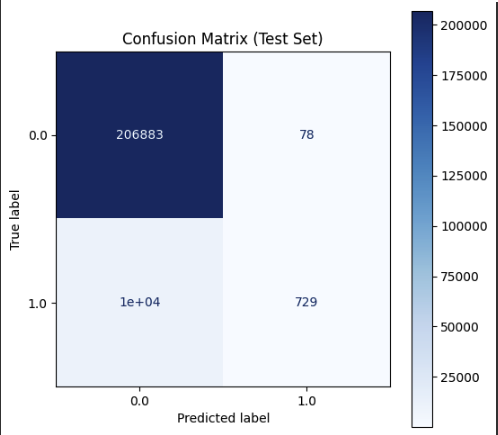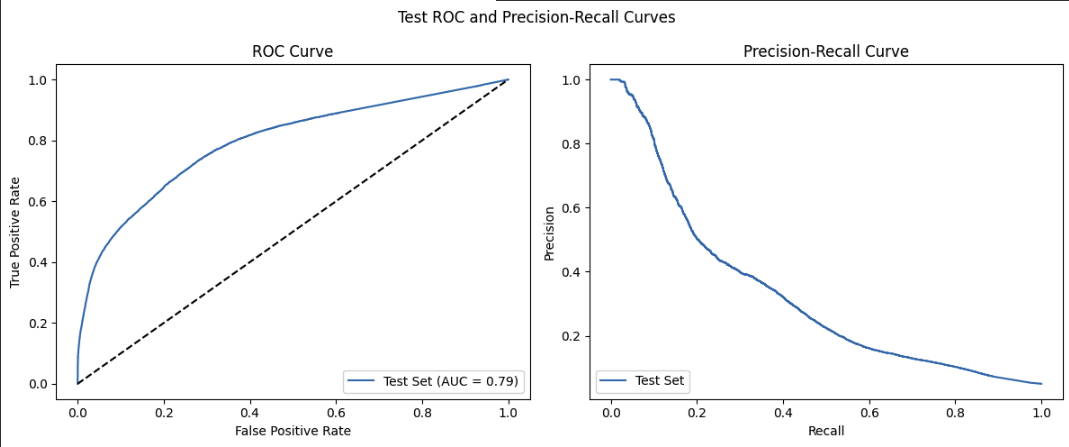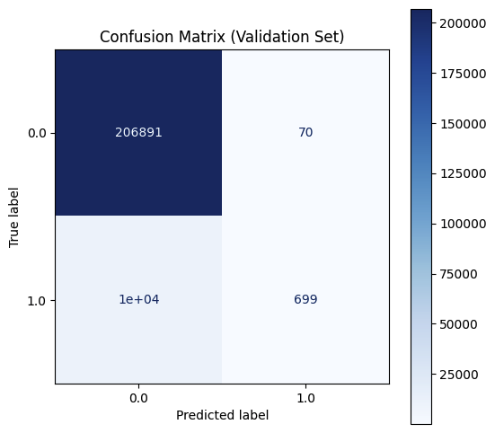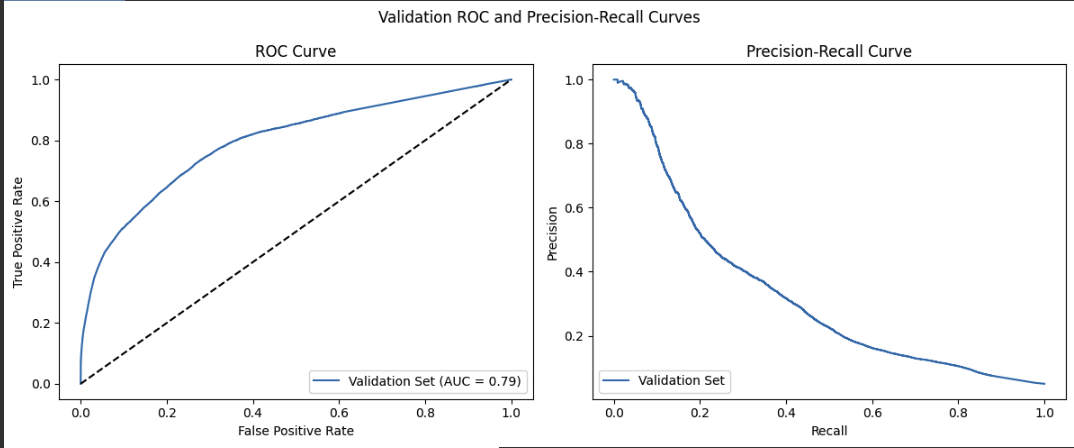

Provides a detailed textual classification report, confusion matrices, and combined plots of ROC and Precision-Recall curves for validation and test sets, focusing on class-level performance analysis.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve

# Validation Metrics
val_probs = best_model(X_val).detach().numpy()
val_preds = (val_probs > 0.5).astype(int)

print("Validation Classification Report:")
print(classification_report(y_val.numpy(), val_preds))
print("Validation Confusion Matrix:")
val_cm = confusion_matrix(y_val.numpy(), val_preds)
print(val_cm)

val_roc_auc = roc_auc_score(y_val.numpy(), val_probs)
print(f"Validation ROC AUC Score: {val_roc_auc}")

# Test Metrics
test_probs = best_model(X_test).detach().numpy()
test_preds = (test_probs > 0.5).astype(int)

print("\nTest Classification Report:")
print(classification_report(y_test.numpy(), test_preds))
print("Test Confusion Matrix:")
test_cm = confusion_matrix(y_test.numpy(), test_preds)
print(test_cm)

test_roc_auc = roc_auc_score(y_test.numpy(), test_probs)
print(f"Test ROC AUC Score: {test_roc_auc}")

# Plot ROC and Precision-Recall Curves
def plot_roc_curve(ax, y_test, y_pred_proba, label):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    ax.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")
    ax.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    ax.legend(loc="lower right")

def plot_precision_recall_curve(ax, y_test, y_pred_proba, label):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax.plot(recall, precision, label=label)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve")
    ax.legend(loc="lower left")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Validation Set
plot_roc_curve(axes[0, 0], y_val.numpy(), val_probs, "Validation Set")
plot_precision_recall_curve(axes[0, 1], y_val.numpy(), val_probs, "Validation Set")
axes[0, 0].set_title("Validation ROC Curve")
axes[0, 1].set_title("Validation Precision-Recall Curve")

# Test Set
plot_roc_curve(axes[1, 0], y_test.numpy(), test_probs, "Test Set")
plot_precision_recall_curve(axes[1, 1], y_test.numpy(), test_probs, "Test Set")
axes[1, 0].set_title("Test ROC Curve")
axes[1, 1].set_title("Test Precision-Recall Curve")

plt.tight_layout()
plt.show()

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(y_val.numpy(), val_preds, ax=axes[0], cmap="Blues")
axes[0].set_title("Validation Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(y_test.numpy(), test_preds, ax=axes[1], cmap="Blues")
axes[1].set_title("Test Confusion Matrix")
plt.show()

Output of the code:

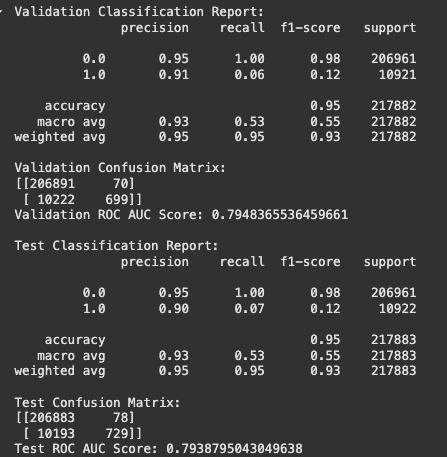
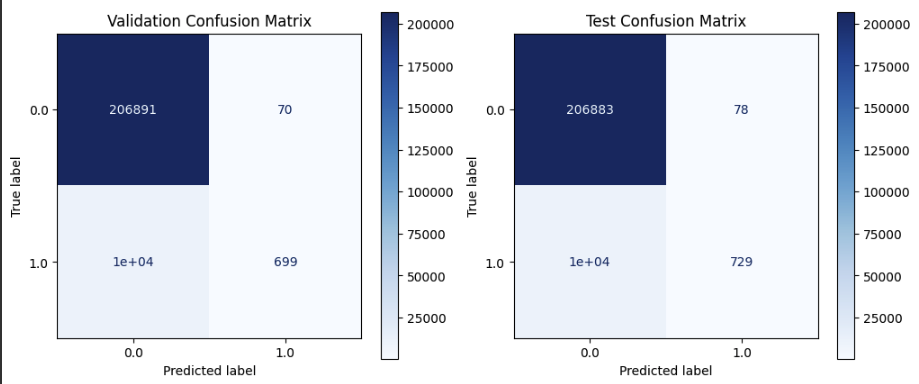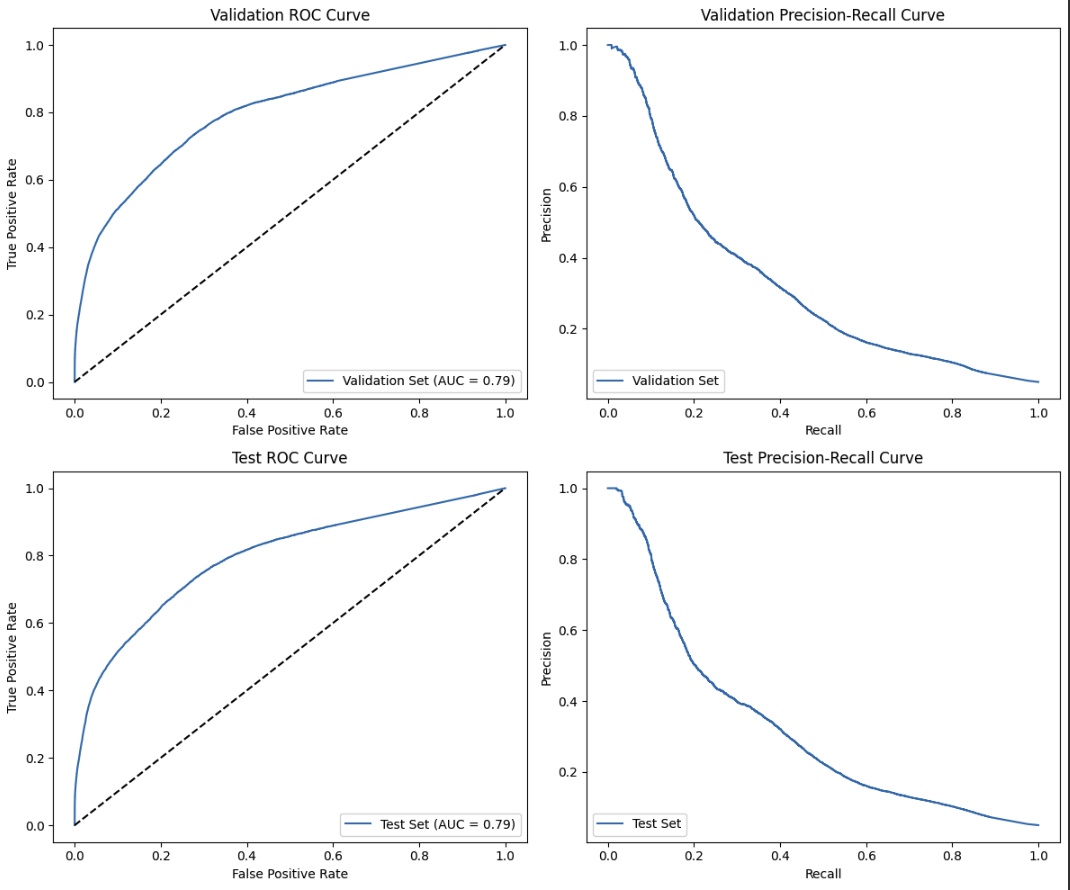

#### Similar to the first, but replaces BCELoss with Focal Loss to address class imbalance by focusing on harder-to-classify samples.

In [178]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
import optuna

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Define the Focal Loss Function
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits).clamp(min=1e-6, max=1 - 1e-6)  # Sigmoid + Clamp
        targets = targets.float()

        loss = -self.alpha * (1 - probs) ** self.gamma * targets * torch.log(probs) - \
               (1 - self.alpha) * probs ** self.gamma * (1 - targets) * torch.log(1 - probs)

        return loss.mean()

# Define the PyTorch Model
class FraudNet(nn.Module):
    def __init__(self, input_dim, hidden_layers, units_per_layer, dropout_rate):
        super(FraudNet, self).__init__()
        layers = []
        current_dim = input_dim

        # Add hidden layers
        for _ in range(hidden_layers):
            layers.append(nn.Linear(current_dim, units_per_layer))
            layers.append(nn.BatchNorm1d(units_per_layer))  # Batch Normalization
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            current_dim = units_per_layer

        # Add output layer (no Sigmoid here)
        layers.append(nn.Linear(current_dim, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)  # Output raw logits

# Objective Function for Optuna
def objective(trial):
    # Hyperparameters to tune
    hidden_layers = trial.suggest_int("hidden_layers", 2, 4)
    units_per_layer = trial.suggest_int("units_per_layer", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.3, step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.01, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-4, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])

    # Initialize the model
    input_dim = X_train.shape[1]
    model = FraudNet(input_dim, hidden_layers, units_per_layer, dropout_rate)
    criterion = FocalLoss(alpha=0.25, gamma=2)  # Use Focal Loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # DataLoader for batching
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    model.train()
    for epoch in range(10):  # Train for 10 epochs
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            logits = model(batch_X)  # Get raw logits
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_logits = model(X_val)
        val_auc = roc_auc_score(y_val.numpy(), torch.sigmoid(val_logits).numpy())  # Use Sigmoid here for AUC

    # Return validation AUC as the objective to optimize
    return val_auc

# Run Optuna for Hyperparameter Tuning
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Best Hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the Best Model with AUC Tracking and Focal Loss
best_model = FraudNet(
    input_dim=X_train.shape[1],
    hidden_layers=best_params["hidden_layers"],
    units_per_layer=best_params["units_per_layer"],
    dropout_rate=best_params["dropout_rate"]
)
criterion = FocalLoss(alpha=0.25, gamma=2)
optimizer = optim.Adam(best_model.parameters(), lr=best_params["learning_rate"], weight_decay=best_params["weight_decay"])

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)

train_aucs = []
val_aucs = []

# Training loop
best_model.train()
for epoch in range(10):  # Train for 10 epochs
    y_train_true = []
    y_train_pred = []

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        logits = best_model(batch_X)  # Get raw logits
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()

        # Store true and predicted values for AUC calculation
        y_train_true.extend(batch_y.numpy())
        y_train_pred.extend(torch.sigmoid(logits).detach().numpy())  # Convert logits to probabilities

    # Calculate training AUC
    train_auc = roc_auc_score(y_train_true, y_train_pred)
    train_aucs.append(train_auc)

    # Validation AUC
    best_model.eval()
    with torch.no_grad():
        val_logits = best_model(X_val)
        val_auc = roc_auc_score(y_val.numpy(), torch.sigmoid(val_logits).numpy())
        val_aucs.append(val_auc)

    best_model.train()  # Switch back to training mode

    print(f"Epoch {epoch + 1}: Train AUC = {train_auc:.4f}, Validation AUC = {val_auc:.4f}")

# Evaluate on Test Set
best_model.eval()
with torch.no_grad():
    test_logits = best_model(X_test).numpy()
    test_probs = torch.sigmoid(torch.tensor(test_logits)).numpy()  # Convert logits to probabilities
    test_auc = roc_auc_score(y_test.numpy(), test_probs)
    print(f"Test AUC: {test_auc:.4f}")

# Output of code:
# [I 2024-11-19 08:57:04,885] A new study created in memory with name: no-name-8736ccbf-694b-445e-840a-21015255db83
# [I 2024-11-19 09:30:39,270] Trial 0 finished with value: 0.8051449819655938 and parameters: {'hidden_layers': 2, 'units_per_layer': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001178448548316156, 'weight_decay': 0.00031993165323804766, 'batch_size': 32}. Best is trial 0 with value: 0.8051449819655938.
# [I 2024-11-19 10:08:54,674] Trial 1 finished with value: 0.7898810837611155 and parameters: {'hidden_layers': 4, 'units_per_layer': 128, 'dropout_rate': 0.3, 'learning_rate': 0.003514002864868591, 'weight_decay': 0.00013996389185492281, 'batch_size': 32}. Best is trial 0 with value: 0.8051449819655938.
# [I 2024-11-19 10:18:57,213] Trial 2 finished with value: 0.8063415020860077 and parameters: {'hidden_layers': 2, 'units_per_layer': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0016157864542530116, 'weight_decay': 0.0008533888080954087, 'batch_size': 64}. Best is trial 2 with value: 0.8063415020860077.
# [I 2024-11-19 10:47:57,376] Trial 3 finished with value: 0.5 and parameters: {'hidden_layers': 3, 'units_per_layer': 128, 'dropout_rate': 0.1, 'learning_rate': 0.008310105471163799, 'weight_decay': 0.0005238785202777933, 'batch_size': 32}. Best is trial 2 with value: 0.8063415020860077.
# [I 2024-11-19 11:10:45,832] Trial 4 finished with value: 0.8020924440709613 and parameters: {'hidden_layers': 2, 'units_per_layer': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001490610809112082, 'weight_decay': 0.00038859247750204625, 'batch_size': 32}. Best is trial 2 with value: 0.8063415020860077.
# [I 2024-11-19 11:29:49,701] Trial 5 finished with value: 0.5 and parameters: {'hidden_layers': 3, 'units_per_layer': 32, 'dropout_rate': 0.3, 'learning_rate': 0.009967884253869408, 'weight_decay': 0.0006259190631157118, 'batch_size': 32}. Best is trial 2 with value: 0.8063415020860077.
# [I 2024-11-19 11:54:04,641] Trial 6 finished with value: 0.5 and parameters: {'hidden_layers': 2, 'units_per_layer': 192, 'dropout_rate': 0.1, 'learning_rate': 0.00881778183966094, 'weight_decay': 0.0005425606083150317, 'batch_size': 32}. Best is trial 2 with value: 0.8063415020860077.
# [I 2024-11-19 12:15:29,259] Trial 7 finished with value: 0.7956594353169826 and parameters: {'hidden_layers': 4, 'units_per_layer': 128, 'dropout_rate': 0.1, 'learning_rate': 0.005996790214089131, 'weight_decay': 0.0001251018505924539, 'batch_size': 64}. Best is trial 2 with value: 0.8063415020860077.
# [I 2024-11-19 13:16:20,006] Trial 8 finished with value: 0.7980007025250819 and parameters: {'hidden_layers': 4, 'units_per_layer': 256, 'dropout_rate': 0.1, 'learning_rate': 0.0014251172904500553, 'weight_decay': 0.0004647577182774816, 'batch_size': 32}. Best is trial 2 with value: 0.8063415020860077.
# [I 2024-11-19 13:30:41,716] Trial 9 finished with value: 0.7708628835676274 and parameters: {'hidden_layers': 2, 'units_per_layer': 160, 'dropout_rate': 0.2, 'learning_rate': 0.005565659358383948, 'weight_decay': 0.0005055561731936407, 'batch_size': 64}. Best is trial 2 with value: 0.8063415020860077.
# Best Hyperparameters: {'hidden_layers': 2, 'units_per_layer': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0016157864542530116, 'weight_decay': 0.0008533888080954087, 'batch_size': 64}
# Epoch 1: Train AUC = 0.7874, Validation AUC = 0.8016
# Epoch 2: Train AUC = 0.7903, Validation AUC = 0.8040
# Epoch 3: Train AUC = 0.7911, Validation AUC = 0.8028
# Epoch 4: Train AUC = 0.7919, Validation AUC = 0.8019
# Epoch 5: Train AUC = 0.7920, Validation AUC = 0.8055
# Epoch 6: Train AUC = 0.7918, Validation AUC = 0.7985
# Epoch 7: Train AUC = 0.7909, Validation AUC = 0.8019
# Epoch 8: Train AUC = 0.7904, Validation AUC = 0.8005
# Epoch 9: Train AUC = 0.7912, Validation AUC = 0.8023
# Epoch 10: Train AUC = 0.7916, Validation AUC = 0.8051
# Test AUC: 0.8029

[I 2024-11-19 08:57:04,885] A new study created in memory with name: no-name-8736ccbf-694b-445e-840a-21015255db83
[I 2024-11-19 09:30:39,270] Trial 0 finished with value: 0.8051449819655938 and parameters: {'hidden_layers': 2, 'units_per_layer': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001178448548316156, 'weight_decay': 0.00031993165323804766, 'batch_size': 32}. Best is trial 0 with value: 0.8051449819655938.
[I 2024-11-19 10:08:54,674] Trial 1 finished with value: 0.7898810837611155 and parameters: {'hidden_layers': 4, 'units_per_layer': 128, 'dropout_rate': 0.3, 'learning_rate': 0.003514002864868591, 'weight_decay': 0.00013996389185492281, 'batch_size': 32}. Best is trial 0 with value: 0.8051449819655938.
[I 2024-11-19 10:18:57,213] Trial 2 finished with value: 0.8063415020860077 and parameters: {'hidden_layers': 2, 'units_per_layer': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0016157864542530116, 'weight_decay': 0.0008533888080954087, 'batch_size': 64}. Best is trial 2 with va

Best Hyperparameters: {'hidden_layers': 2, 'units_per_layer': 64, 'dropout_rate': 0.1, 'learning_rate': 0.0016157864542530116, 'weight_decay': 0.0008533888080954087, 'batch_size': 64}
Epoch 1: Train AUC = 0.7874, Validation AUC = 0.8016
Epoch 2: Train AUC = 0.7903, Validation AUC = 0.8040
Epoch 3: Train AUC = 0.7911, Validation AUC = 0.8028
Epoch 4: Train AUC = 0.7919, Validation AUC = 0.8019
Epoch 5: Train AUC = 0.7920, Validation AUC = 0.8055
Epoch 6: Train AUC = 0.7918, Validation AUC = 0.7985
Epoch 7: Train AUC = 0.7909, Validation AUC = 0.8019
Epoch 8: Train AUC = 0.7904, Validation AUC = 0.8005
Epoch 9: Train AUC = 0.7912, Validation AUC = 0.8023
Epoch 10: Train AUC = 0.7916, Validation AUC = 0.8051
Test AUC: 0.8029


Evaluates and visualizes the model's performance with overall metrics (AUC, Precision, Recall, F1), ROC and Precision-Recall curves, and confusion matrices for both validation and test sets.

Validation Set Metrics:
AUC: 0.8051
Precision: 1.0000
Recall: 0.0137
F1 Score: 0.0271

Test Set Metrics:
AUC: 0.8029
Precision: 1.0000
Recall: 0.0141
F1 Score: 0.0278


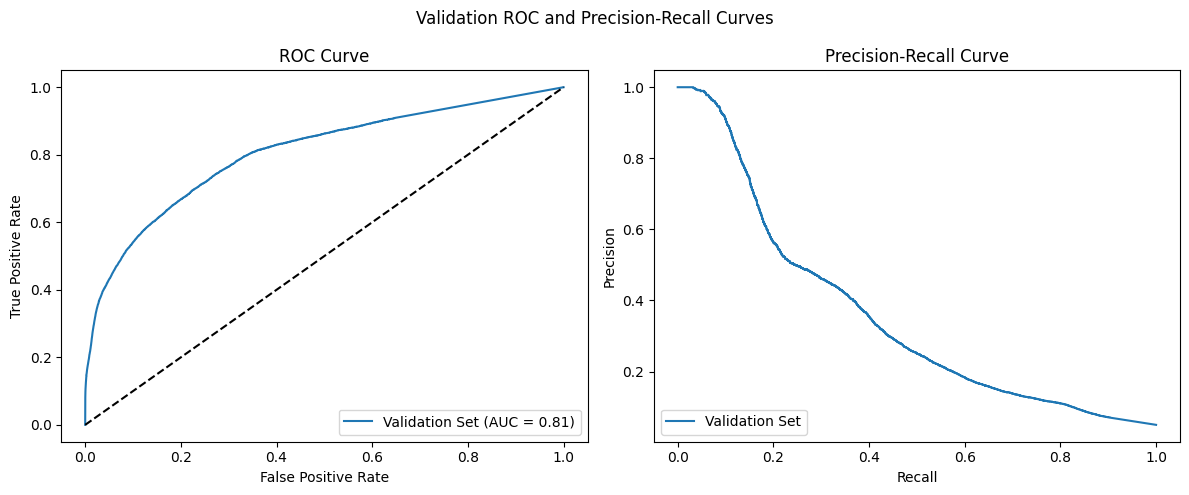

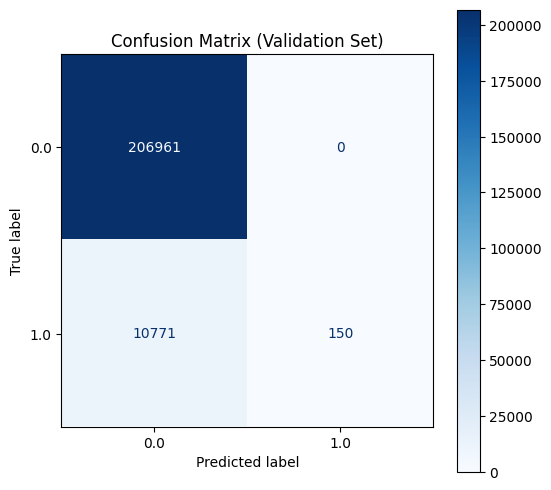

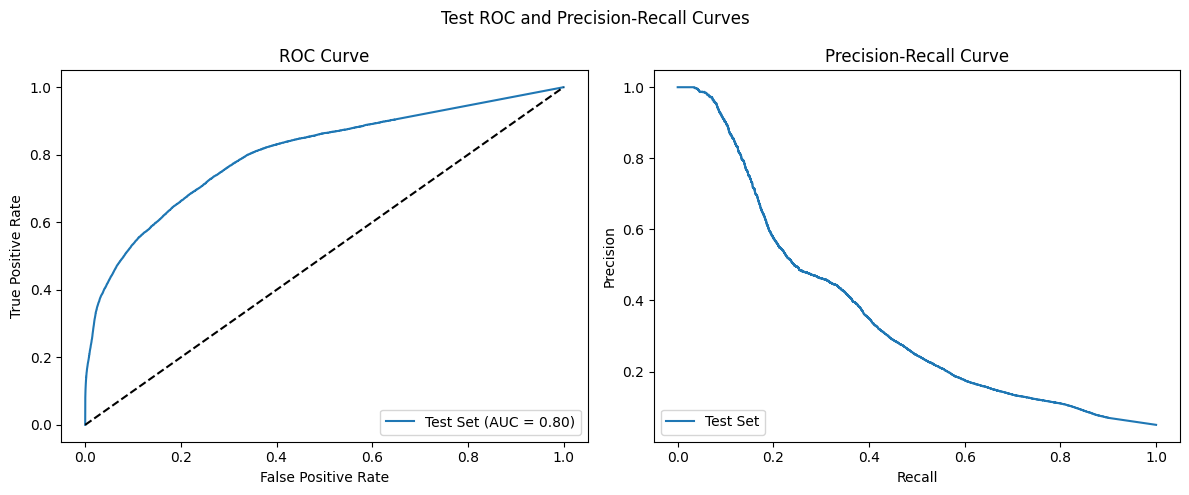

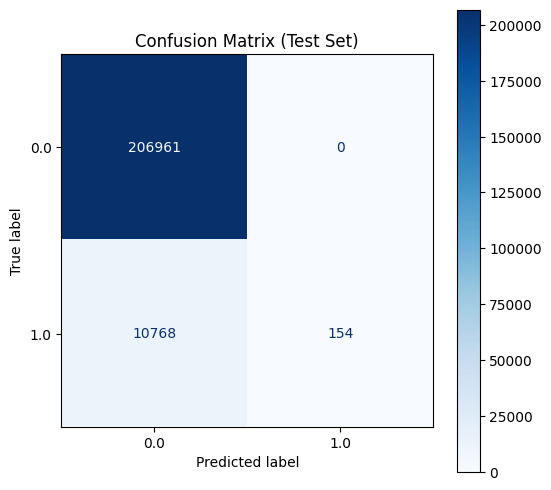

In [179]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate metrics for Validation Set
val_probs = best_model(X_val).detach().numpy()  # Predicted probabilities
val_preds = (val_probs > 0.5).astype(int)  # Predicted labels

val_auc = roc_auc_score(y_val.numpy(), val_probs)
val_precision = precision_score(y_val.numpy(), val_preds)
val_recall = recall_score(y_val.numpy(), val_preds)
val_f1 = f1_score(y_val.numpy(), val_preds)

print("Validation Set Metrics:")
print(f"AUC: {val_auc:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Calculate metrics for Test Set
test_probs = best_model(X_test).detach().numpy()  # Predicted probabilities
test_preds = (test_probs > 0.5).astype(int)  # Predicted labels

test_auc = roc_auc_score(y_test.numpy(), test_probs)
test_precision = precision_score(y_test.numpy(), test_preds)
test_recall = recall_score(y_test.numpy(), test_preds)
test_f1 = f1_score(y_test.numpy(), test_preds)

print("\nTest Set Metrics:")
print(f"AUC: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Plotting ROC and Precision-Recall Curves
def plot_roc_curve(ax, y_true, y_probs, label):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc_score = roc_auc_score(y_true, y_probs)
    ax.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")
    ax.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    ax.legend(loc="lower right")

def plot_precision_recall_curve(ax, y_true, y_probs, label):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    ax.plot(recall, precision, label=label)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve")
    ax.legend(loc="lower left")

# Validation Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_roc_curve(axes[0], y_val.numpy(), val_probs, "Validation Set")
plot_precision_recall_curve(axes[1], y_val.numpy(), val_probs, "Validation Set")
plt.suptitle("Validation ROC and Precision-Recall Curves")
plt.tight_layout()
plt.show()

# Confusion Matrix for Validation Set
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_val.numpy(), val_preds, ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix (Validation Set)")
plt.show()

# Test Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_roc_curve(axes[0], y_test.numpy(), test_probs, "Test Set")
plot_precision_recall_curve(axes[1], y_test.numpy(), test_probs, "Test Set")
plt.suptitle("Test ROC and Precision-Recall Curves")
plt.tight_layout()
plt.show()

# Confusion Matrix for Test Set
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test.numpy(), test_preds, ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix (Test Set)")
plt.show()


Provides a detailed textual classification report, confusion matrices, and combined plots of ROC and Precision-Recall curves for validation and test sets, focusing on class-level performance analysis.

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97    206961
         1.0       1.00      0.01      0.03     10921

    accuracy                           0.95    217882
   macro avg       0.98      0.51      0.50    217882
weighted avg       0.95      0.95      0.93    217882

Validation Confusion Matrix:
[[206961      0]
 [ 10771    150]]
Validation ROC AUC Score: 0.805115644348775

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97    206961
         1.0       1.00      0.01      0.03     10922

    accuracy                           0.95    217883
   macro avg       0.98      0.51      0.50    217883
weighted avg       0.95      0.95      0.93    217883

Test Confusion Matrix:
[[206961      0]
 [ 10768    154]]
Test ROC AUC Score: 0.8028887300452274


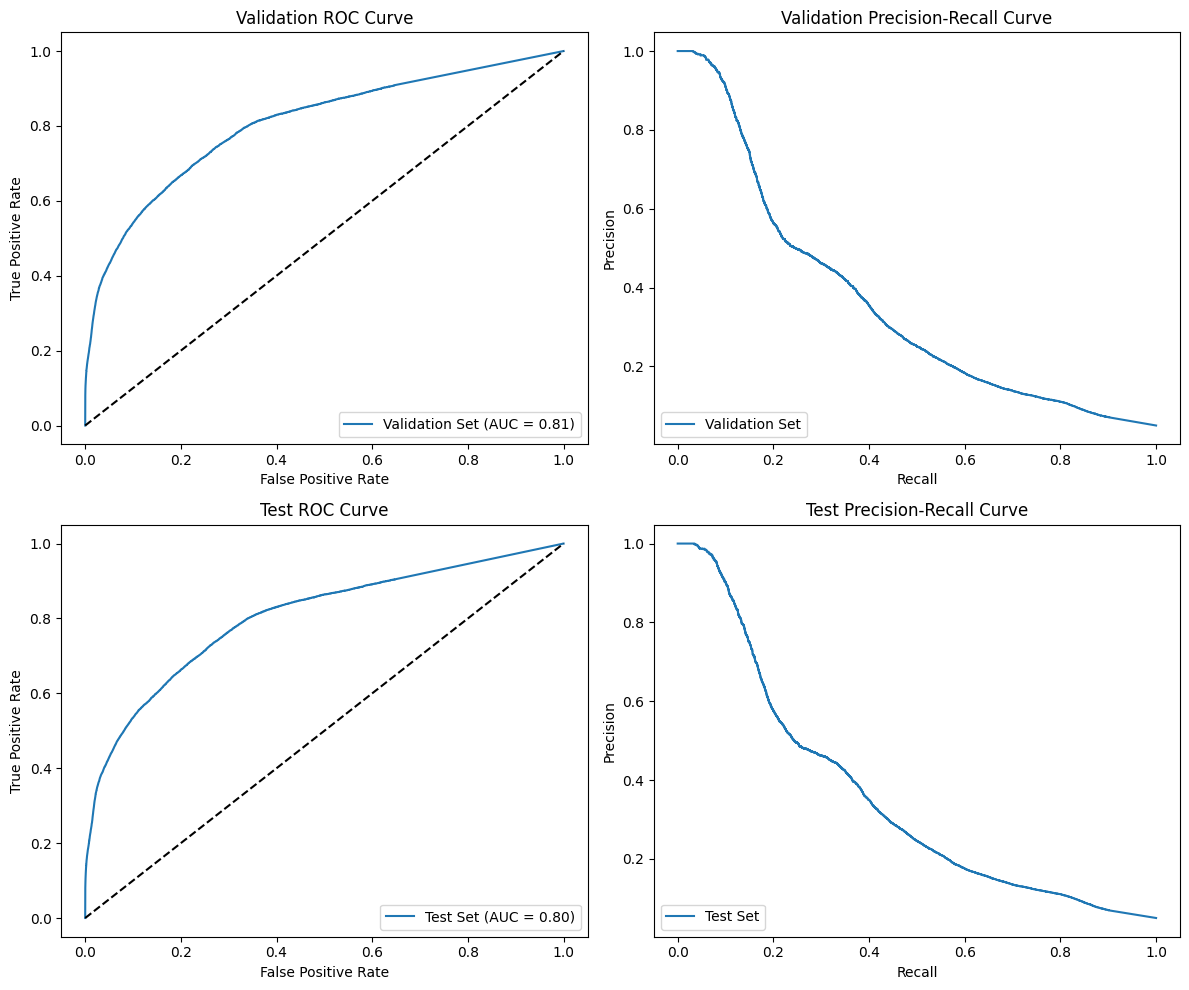

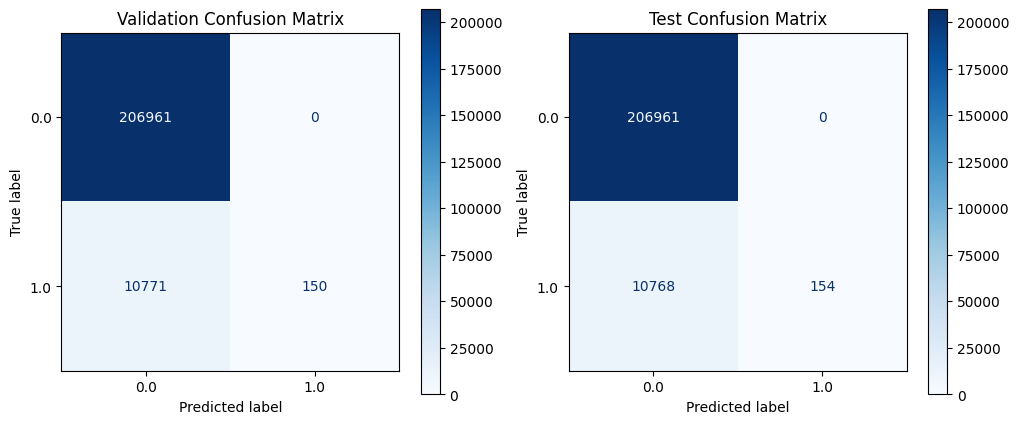

In [180]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve

# Validation Metrics
val_probs = best_model(X_val).detach().numpy()
val_preds = (val_probs > 0.5).astype(int)

print("Validation Classification Report:")
print(classification_report(y_val.numpy(), val_preds))
print("Validation Confusion Matrix:")
val_cm = confusion_matrix(y_val.numpy(), val_preds)
print(val_cm)

val_roc_auc = roc_auc_score(y_val.numpy(), val_probs)
print(f"Validation ROC AUC Score: {val_roc_auc}")

# Test Metrics
test_probs = best_model(X_test).detach().numpy()
test_preds = (test_probs > 0.5).astype(int)

print("\nTest Classification Report:")
print(classification_report(y_test.numpy(), test_preds))
print("Test Confusion Matrix:")
test_cm = confusion_matrix(y_test.numpy(), test_preds)
print(test_cm)

test_roc_auc = roc_auc_score(y_test.numpy(), test_probs)
print(f"Test ROC AUC Score: {test_roc_auc}")

# Plot ROC and Precision-Recall Curves
def plot_roc_curve(ax, y_test, y_pred_proba, label):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    ax.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")
    ax.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    ax.legend(loc="lower right")

def plot_precision_recall_curve(ax, y_test, y_pred_proba, label):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax.plot(recall, precision, label=label)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve")
    ax.legend(loc="lower left")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Validation Set
plot_roc_curve(axes[0, 0], y_val.numpy(), val_probs, "Validation Set")
plot_precision_recall_curve(axes[0, 1], y_val.numpy(), val_probs, "Validation Set")
axes[0, 0].set_title("Validation ROC Curve")
axes[0, 1].set_title("Validation Precision-Recall Curve")

# Test Set
plot_roc_curve(axes[1, 0], y_test.numpy(), test_probs, "Test Set")
plot_precision_recall_curve(axes[1, 1], y_test.numpy(), test_probs, "Test Set")
axes[1, 0].set_title("Test ROC Curve")
axes[1, 1].set_title("Test Precision-Recall Curve")

plt.tight_layout()
plt.show()

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(y_val.numpy(), val_preds, ax=axes[0], cmap="Blues")
axes[0].set_title("Validation Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(y_test.numpy(), test_preds, ax=axes[1], cmap="Blues")
axes[1].set_title("Test Confusion Matrix")
plt.show()
